In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from scipy.stats import jarque_bera

# Seaborn for plotting and styling
import seaborn as sns

In [2]:
df = pd.read_csv('~/2023_MSDS/train.csv') #change this to your paths
#df = pd.read_csv('train.csv')
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Based on our initial hypothesis, we have selected the model:
Formula_1 = 'SalePrice ~ LotArea + BsmtFinSF1 + TotalBsmtSF + GrLivArea + GarageCars + MSZoning + Condition1 + Neighborhood + C(OverallQual) + OverallCond + YearBuilt + Fence + YrSold + SaleCondition'

Now, let's check the correlation matrix to see how the numerical predictors are related to each other


# EDA

/var/folders/vy/x91b4v216pz4sptwpws0q_s40000gn/T/ipykernel_35162/3398626257.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  'MSZoning','Condition1','YrSold','SaleCondition']].corr()


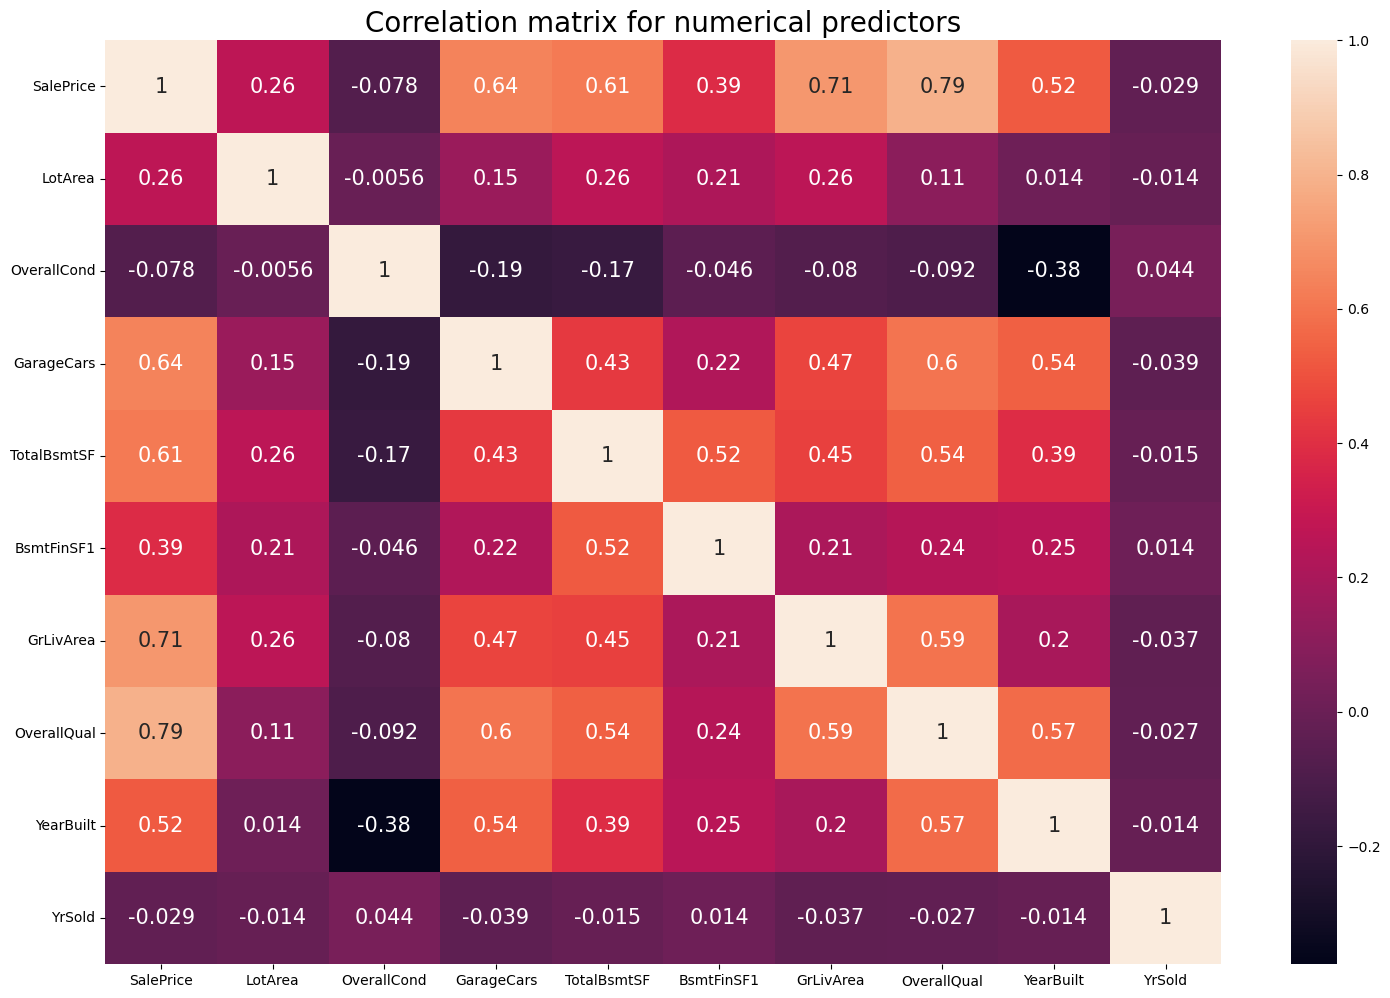

In [4]:
#calculate the correlations between each pair of numerical variables
corr = df[['SalePrice','LotArea','OverallCond' , 'GarageCars' , 'TotalBsmtSF' , 
           'BsmtFinSF1' , 'GrLivArea' , 'OverallQual' , 'YearBuilt' , 'Neighborhood',
           'MSZoning','Condition1','YrSold','SaleCondition']].corr()

#set figure size
plt.figure(figsize=(18,12))

#plot heatmap
ax = sns.heatmap(corr, annot=True, annot_kws={"size": 15})

#set yticks 
plt.yticks(rotation=0)
plt.title('Correlation matrix for numerical predictors',fontsize=20)

plt.show()

In [5]:
corr

,SalePrice,LotArea,OverallCond,GarageCars,TotalBsmtSF,BsmtFinSF1,GrLivArea,OverallQual,YearBuilt,YrSold
SalePrice,1.000000,0.263843,-0.077856,0.640409,0.613581,0.386420,0.708624,0.790982,0.522897,-0.028923
LotArea,0.263843,1.000000,-0.005636,0.154871,0.260833,0.214103,0.263116,0.105806,0.014228,-0.014261
OverallCond,-0.077856,-0.005636,1.000000,-0.185758,-0.171098,-0.046231,-0.079686,-0.091932,-0.375983,0.043950
GarageCars,0.640409,0.154871,-0.185758,1.000000,0.434585,0.224054,0.467247,0.600671,0.537850,-0.039117
TotalBsmtSF,0.613581,0.260833,-0.171098,0.434585,1.000000,0.522396,0.454868,0.537808,0.391452,-0.014969
BsmtFinSF1,0.386420,0.214103,-0.046231,0.224054,0.522396,1.000000,0.208171,0.239666,0.249503,0.014359
GrLivArea,0.708624,0.263116,-0.079686,0.467247,0.454868,0.208171,1.000000,0.593007,0.199010,-0.036526
OverallQual,0.790982,0.105806,-0.091932,0.600671,0.537808,0.239666,0.593007,1.000000,0.572323,-0.027347
YearBuilt,0.522897,0.014228,-0.375983,0.537850,0.391452,0.249503,0.199010,0.572323,1.000000,-0.013618
YrSold,-0.028923,-0.014261,0.043950,-0.039117,-0.014969,0.014359,-0.036526,-0.027347,-0.013618,1.000000


Observations from the correlation heatmap:
1. We can see that OverallCond and YrSold are the least correlated to the other predictor variables
2. The correlation for the rest of the predictor variables looks reasonably good to us!

Next, we wanted to see how houses are spread out across neighbourhoods

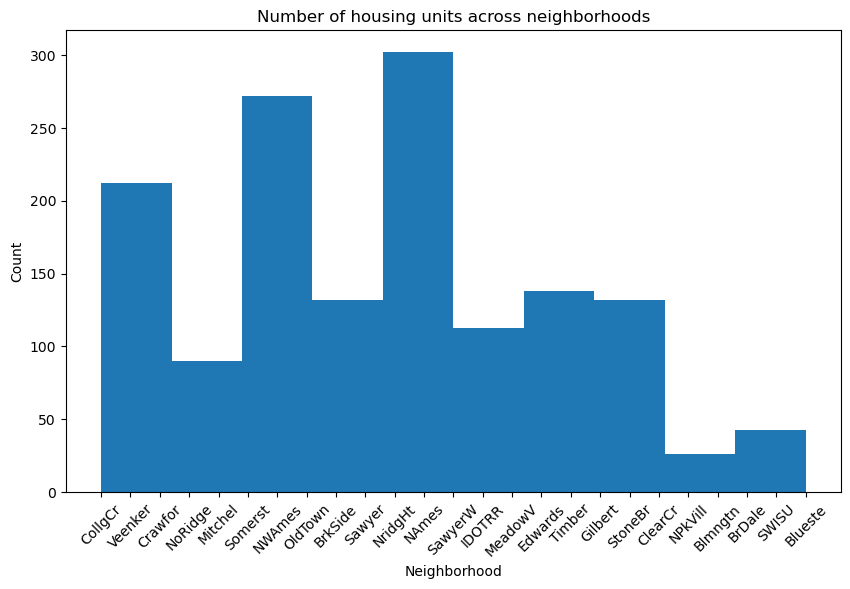

In [6]:
x = df["Neighborhood"]

fig, ax = plt.subplots(figsize=(10,6)) 
ax.hist(x) #bar plot takes at least x and y axis as arguments
plt.xticks(rotation=45)
plt.xlabel('Neighborhood')
plt.ylabel('Count')
plt.title('Number of housing units across neighborhoods')
plt.show()

The next categorical variable in our hypothesized model is Fence, however we are observing a lot of NULL values in the data! Might not be an ideal predictor. Let us replace the NULL values with 'NA'

In [7]:
df['Fence']=df['Fence'].fillna('NA')
df['Fence'].unique()
df['Fence'].value_counts()

NA       1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

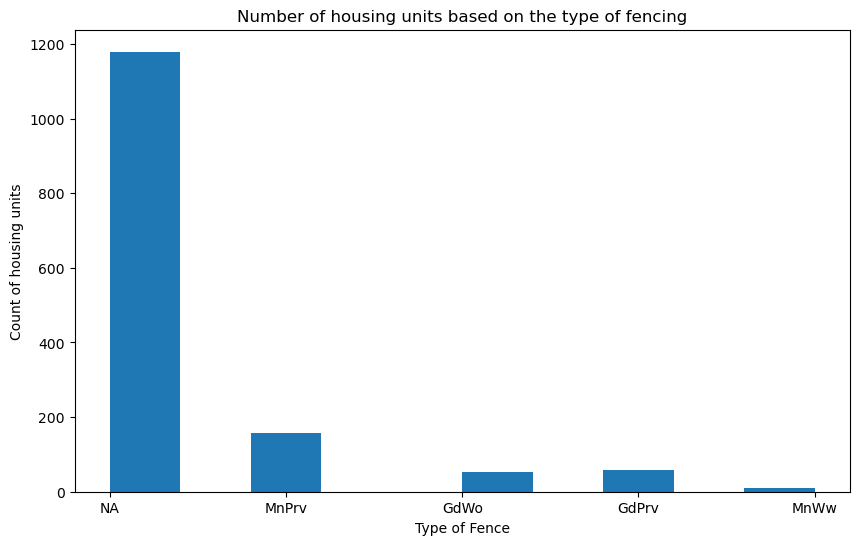

In [8]:
x = df['Fence']
fig, ax = plt.subplots(figsize=(10,6)) 
ax.hist(x) #bar plot takes at least x and y axis as arguments
# plt.xticks(rotation=45)
plt.xlabel('Type of Fence')
plt.ylabel('Count of housing units')
plt.title('Number of housing units based on the type of fencing')
plt.show()

Next, we want to see the relation between a few numerical variables

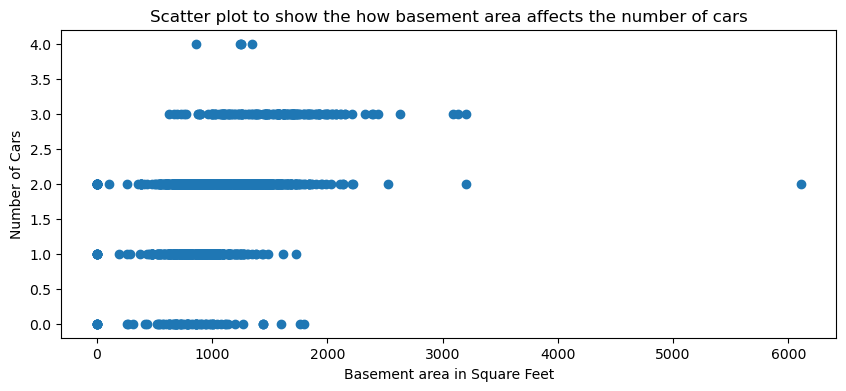

In [9]:
fig, ax = plt.subplots(figsize=(10,4)) 
ax.scatter(df['TotalBsmtSF'],df['GarageCars'])
plt.xlabel('Basement area in Square Feet')
plt.ylabel('Number of Cars')
plt.title('Scatter plot to show the how basement area affects the number of cars')
plt.show()

In [10]:
df['TotalBsmtSF'].loc[df['TotalBsmtSF']>6000]

1298    6110
Name: TotalBsmtSF, dtype: int64

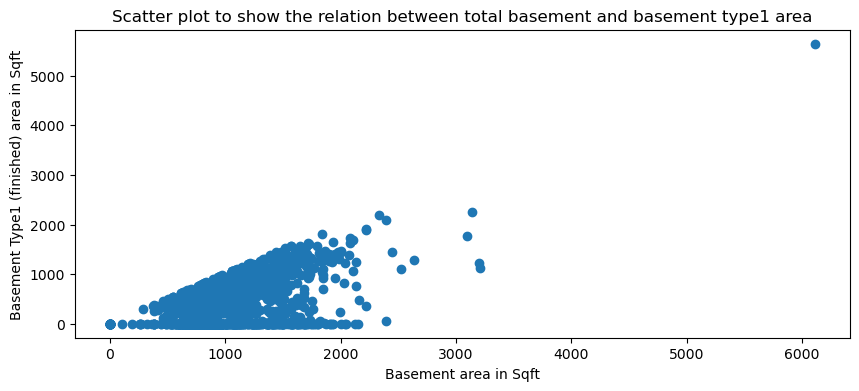

In [11]:
fig, ax = plt.subplots(figsize=(10,4)) 
ax.scatter(df['TotalBsmtSF'],df['BsmtFinSF1'])
plt.xlabel('Basement area in Sqft')
plt.ylabel('Basement Type1 (finished) area in Sqft')
plt.title('Scatter plot to show the relation between total basement and basement type1 area')
plt.show()

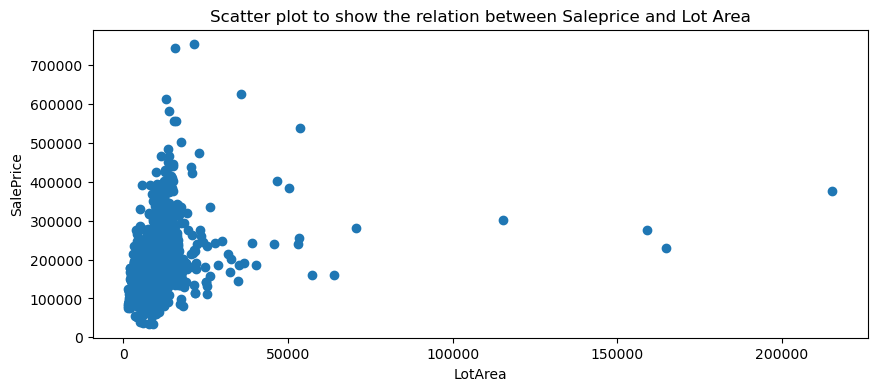

In [12]:
fig, ax = plt.subplots(figsize=(10,4)) 
ax.scatter(df['LotArea'],df['SalePrice'])
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.title('Scatter plot to show the relation between Saleprice and Lot Area')
plt.show()

From these scatter plots, we can see that there may be a few outliers in the data. We can check for these later in the model diagnosis 

# Correlation

In [13]:
df.corr()

/var/folders/vy/x91b4v216pz4sptwpws0q_s40000gn/T/ipykernel_35162/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


# First Model

We can remove Fence, Condition1, and Yearsold since the p_values are all greater .5. We can see that they are not good predictors from this mode.

In [14]:

model =smf.ols('SalePrice ~ LotArea + BsmtFinSF1 + TotalBsmtSF + GrLivArea + GarageCars + MSZoning + Condition1 + Neighborhood + C(OverallQual) + OverallCond + YearBuilt + Fence + YrSold + SaleCondition',data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     139.3
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:48:53   Log-Likelihood:                -17105.
No. Observations:                1460   AIC:                         3.434e+04
Df Residuals:                    1397   BIC:                         3.467e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -9.718e+05   1.25e+06     -0.780      0.435   -3.42e+06    1.47e+06
MSZoning[T.FV]             2.13e+04   1.44e+04      1.478      0.140   -6972.055    4.96e+04
MSZoning[T.RH]             2.42e+04   1.44e+04      1.678      0.094   -4084.995    5.25e+04
MSZoning[T.RL]            3.195e+04    1.2e+04      2.671      0.008    8482.504    5.54e+04
MSZoning[T.RM]            2.313e+04   1.13e+04      2.049      0.041     981.056    4.53e+04
Condition1[T.Feedr]      -6523.4844   5827.149     -1.119      0.263    -1.8e+04    4907.422
Condition1[T.Norm]        9379.3924   4780.079      1.962      0.050       2.485    1.88e+04
Condition1[T.PosA]         1.64e+04    1.2e+04      1.369      0.171   -7099.104    3.99e+04
Condition1[T.PosN]       -6787.0084   8557.341     -0.793      0.428   -2.36e+04    9999.615
Condition1[T.RRAe]       -1.398e+04   1.07e+04     -1.303      0.193    -3.5e+04    7071.669
Condition1[T.RRAn]        6112.3188   7867.601      0.777      0.437   -9321.267    2.15e+04
Condition1[T.RRNe]       -2695.6386   2.24e+04     -0.120      0.904   -4.66e+04    4.12e+04
Condition1[T.RRNn]        2190.4221   1.48e+04      0.148      0.882   -2.68e+04    3.11e+04
Neighborhood[T.Blueste]  -1.428e+04   2.36e+04     -0.604      0.546   -6.06e+04    3.21e+04
Neighborhood[T.BrDale]   -1.218e+04   1.19e+04     -1.027      0.305   -3.54e+04    1.11e+04
Neighborhood[T.BrkSide]   7039.7348   9947.770      0.708      0.479   -1.25e+04    2.66e+04
Neighborhood[T.ClearCr]   1.919e+04      1e+04      1.913      0.056    -490.739    3.89e+04
Neighborhood[T.CollgCr]   7661.5489   7899.844      0.970      0.332   -7835.286    2.32e+04
Neighborhood[T.Crawfor]   2.717e+04   9479.533      2.866      0.004    8573.364    4.58e+04
Neighborhood[T.Edwards]  -1.382e+04   8794.333     -1.571      0.116   -3.11e+04    3432.930
Neighborhood[T.Gilbert]   3898.2161   8386.196      0.465      0.642   -1.26e+04    2.03e+04
Neighborhood[T.IDOTRR]    4938.8537   1.14e+04      0.432      0.666   -1.75e+04    2.74e+04
Neighborhood[T.MeadowV]  -1.348e+04   1.19e+04     -1.130      0.259   -3.69e+04    9929.282
Neighborhood[T.Mitchel]  -3930.5377   8977.851     -0.438      0.662   -2.15e+04    1.37e+04
Neighborhood[T.NAmes]    -1089.9427   8358.417     -0.130      0.896   -1.75e+04    1.53e+04
Neighborhood[T.NPkVill]  -1.032e+04   1.29e+04     -0.800      0.424   -3.56e+04     1.5e+04
Neighborhood[T.NWAmes]    -801.4687   8663.076     -0.093      0.926   -1.78e+04    1.62e+04
Neighborhood[T.NoRidge]   5.193e+04   9260.891      5.607      0.000    3.38e+04    7.01e+04
Neighborhood[T.NridgHt]   3.316e+04   8495.164      3.903      0.000    1.65e+04    4.98e+04
Neighborhood[T.OldTown]  -5181.4952   1.02e+04     -0.509      0.611   -2.51e+04    1.48e+04
Neighborhood[T

# Second Model

In [15]:
model =smf.ols('SalePrice ~ LotArea + BsmtFinSF1 + TotalBsmtSF + GrLivArea + GarageCars + MSZoning + Neighborhood + C(OverallQual) + OverallCond + YearBuilt + SaleCondition',data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     173.1
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:49:04   Log-Likelihood:                -17122.
No. Observations:                1460   AIC:                         3.434e+04
Df Residuals:                    1410   BIC:                         3.461e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7.444e+05    1.3e+05     -5.714      0.000      -1e+06   -4.89e+05
MSZoning[T.FV]            2.657e+04   1.44e+04      1.847      0.065   -1650.724    5.48e+04
MSZoning[T.RH]            2.484e+04   1.45e+04      1.719      0.086   -3505.391    5.32e+04
MSZoning[T.RL]            3.372e+04    1.2e+04      2.811      0.005    1.02e+04    5.72e+04
MSZoning[T.RM]            2.414e+04   1.13e+04      2.131      0.033    1921.679    4.64e+04
Neighborhood[T.Blueste]  -1.005e+04   2.34e+04     -0.430      0.667   -5.59e+04    3.58e+04
Neighborhood[T.BrDale]   -1.051e+04   1.19e+04     -0.882      0.378   -3.39e+04    1.29e+04
Neighborhood[T.BrkSide]   6472.6020   9941.268      0.651      0.515    -1.3e+04     2.6e+04
Neighborhood[T.ClearCr]   1.918e+04   1.01e+04      1.899      0.058    -629.870     3.9e+04
Neighborhood[T.CollgCr]   8383.5183   7949.656      1.055      0.292   -7210.907     2.4e+04
Neighborhood[T.Crawfor]   2.888e+04   9520.433      3.034      0.002    1.02e+04    4.76e+04
Neighborhood[T.Edwards]  -1.333e+04   8836.847     -1.508      0.132   -3.07e+04    4009.166
Neighborhood[T.Gilbert]   4182.6901   8419.337      0.497      0.619   -1.23e+04    2.07e+04
Neighborhood[T.IDOTRR]    5993.0420   1.14e+04      0.523      0.601   -1.65e+04    2.85e+04
Neighborhood[T.MeadowV]  -1.101e+04    1.2e+04     -0.921      0.357   -3.45e+04    1.25e+04
Neighborhood[T.Mitchel]  -2540.0366   9017.250     -0.282      0.778   -2.02e+04    1.51e+04
Neighborhood[T.NAmes]    -1375.0483   8384.315     -0.164      0.870   -1.78e+04    1.51e+04
Neighborhood[T.NPkVill]  -9277.1676    1.3e+04     -0.716      0.474   -3.47e+04    1.61e+04
Neighborhood[T.NWAmes]   -1368.6368   8642.594     -0.158      0.874   -1.83e+04    1.56e+04
Neighborhood[T.NoRidge]   5.373e+04   9313.900      5.768      0.000    3.55e+04     7.2e+04
Neighborhood[T.NridgHt]    3.41e+04   8547.759      3.989      0.000    1.73e+04    5.09e+04
Neighborhood[T.OldTown]  -5431.5998   1.02e+04     -0.532      0.595   -2.54e+04    1.46e+04
Neighborhood[T.SWISU]    -3594.6787    1.1e+04     -0.328      0.743   -2.51e+04    1.79e+04
Neighborhood[T.Sawyer]   -3911.5367   8898.972     -0.440      0.660   -2.14e+04    1.35e+04
Neighborhood[T.SawyerW]   5634.5717   8731.723      0.645      0.519   -1.15e+04    2.28e+04
Neighborhood[T.Somerst]   1.638e+04   1.02e+04      1.613      0.107   -3539.387    3.63e+04
Neighborhood[T.StoneBr]    4.53e+04   9949.908      4.552      0.000    2.58e+04    6.48e+04
Neighborhood[T.Timber]     1.09e+04   9279.585      1.175      0.240   -7299.449    2.91e+04
Neighborhood[T.Veenker]   2.686e+04   1.21e+04      2.213      0.027    3051.187    5.07e+04
C(OverallQual)[T.2]      -7048.0938   2.83e+04     -0.249      0.804   -6.26e+04    4.85e+04
C(OverallQual)

see that model did not change in R^2 and adjusted R^2

# Checking Multicollinearity

In [16]:
y, X_new = dmatrices('SalePrice ~ LotArea + BsmtFinSF1 + TotalBsmtSF + GrLivArea + GarageCars + MSZoning + Neighborhood + C(OverallQual) + OverallCond + YearBuilt + SaleCondition', data=df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns
print(vif)

      VIF Factor                  features
0   26627.878459                 Intercept
1      13.814843            MSZoning[T.FV]
2       3.550552            MSZoning[T.RH]
3      37.652506            MSZoning[T.RL]
4      25.555713            MSZoning[T.RM]
5       1.171628   Neighborhood[T.Blueste]
6       2.415197    Neighborhood[T.BrDale]
7       5.914122   Neighborhood[T.BrkSide]
8       3.007831   Neighborhood[T.ClearCr]
9       9.138815   Neighborhood[T.CollgCr]
10      4.793196   Neighborhood[T.Crawfor]
11      7.815634   Neighborhood[T.Edwards]
12      5.691244   Neighborhood[T.Gilbert]
13      5.079332    Neighborhood[T.IDOTRR]
14      2.582931   Neighborhood[T.MeadowV]
15      4.137157   Neighborhood[T.Mitchel]
16     14.375246     Neighborhood[T.NAmes]
17      1.613234   Neighborhood[T.NPkVill]
18      5.565679    Neighborhood[T.NWAmes]
19      3.714155   Neighborhood[T.NoRidge]
20      5.725957   Neighborhood[T.NridgHt]
21     11.663692   Neighborhood[T.OldTown]
22      3.1

SEE that Neighborhood[T.NAmes],and MS zoning and Overall Quaniity are all high. We remove MSZoning

In [17]:
model =smf.ols('SalePrice ~ LotArea + BsmtFinSF1 + TotalBsmtSF + GrLivArea + GarageCars + Neighborhood + C(OverallQual) + OverallCond + YearBuilt + SaleCondition',data=df).fit()
model.summary() #0.859

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     187.2
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:49:22   Log-Likelihood:                -17128.
No. Observations:                1460   AIC:                         3.435e+04
Df Residuals:                    1414   BIC:                         3.459e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -6.897e+05   1.29e+05     -5.359      0.000   -9.42e+05   -4.37e+05
Neighborhood[T.Blueste]  -1.858e+04   2.31e+04     -0.804      0.421   -6.39e+04    2.67e+04
Neighborhood[T.BrDale]   -1.914e+04   1.12e+04     -1.708      0.088   -4.11e+04    2841.477
Neighborhood[T.BrkSide]   1506.8965   9607.593      0.157      0.875   -1.73e+04    2.04e+04
Neighborhood[T.ClearCr]   1.922e+04   1.01e+04      1.899      0.058    -631.047    3.91e+04
Neighborhood[T.CollgCr]   8297.7343   7969.846      1.041      0.298   -7336.260    2.39e+04
Neighborhood[T.Crawfor]   2.795e+04   9529.064      2.933      0.003    9256.857    4.66e+04
Neighborhood[T.Edwards]  -1.408e+04   8831.300     -1.594      0.111   -3.14e+04    3246.080
Neighborhood[T.Gilbert]   4997.6842   8435.564      0.592      0.554   -1.15e+04    2.15e+04
Neighborhood[T.IDOTRR]   -9182.2098   1.02e+04     -0.900      0.368   -2.92e+04    1.08e+04
Neighborhood[T.MeadowV]  -2.008e+04   1.12e+04     -1.799      0.072    -4.2e+04    1812.725
Neighborhood[T.Mitchel]  -2916.3690   9030.617     -0.323      0.747   -2.06e+04    1.48e+04
Neighborhood[T.NAmes]    -1188.8146   8400.884     -0.142      0.887   -1.77e+04    1.53e+04
Neighborhood[T.NPkVill]  -8205.3712    1.3e+04     -0.632      0.528   -3.37e+04    1.73e+04
Neighborhood[T.NWAmes]    -856.3263   8663.243     -0.099      0.921   -1.79e+04    1.61e+04
Neighborhood[T.NoRidge]   5.417e+04   9339.141      5.800      0.000    3.58e+04    7.25e+04
Neighborhood[T.NridgHt]   3.426e+04   8568.336      3.999      0.000    1.75e+04    5.11e+04
Neighborhood[T.OldTown]  -1.395e+04   9369.123     -1.489      0.137   -3.23e+04    4424.443
Neighborhood[T.SWISU]    -5201.6889   1.09e+04     -0.477      0.633   -2.66e+04    1.62e+04
Neighborhood[T.Sawyer]   -3963.8669   8912.830     -0.445      0.657   -2.14e+04    1.35e+04
Neighborhood[T.SawyerW]   5765.3322   8731.261      0.660      0.509   -1.14e+04    2.29e+04
Neighborhood[T.Somerst]    1.16e+04   8237.369      1.408      0.159   -4561.634    2.78e+04
Neighborhood[T.StoneBr]   4.553e+04   9974.833      4.564      0.000     2.6e+04    6.51e+04
Neighborhood[T.Timber]    1.115e+04   9304.665      1.199      0.231   -7099.047    2.94e+04
Neighborhood[T.Veenker]   2.704e+04   1.22e+04      2.222      0.026    3166.235    5.09e+04
C(OverallQual)[T.2]      -1.689e+04   2.82e+04     -0.599      0.549   -7.22e+04    3.85e+04
C(OverallQual)[T.3]       -1.78e+04    2.3e+04     -0.774      0.439   -6.29e+04    2.73e+04
C(OverallQual)[T.4]      -1.549e+04   2.23e+04     -0.696      0.487   -5.92e+04    2.82e+04
C(OverallQual)[T.5]      -1.479e+04   2.23e+04     -0.664      0.507   -5.85e+04    2.89e+04
C(OverallQual)[T.6]      -8801.5777   2.24e+04     -0.393      0.694   -5.27e+04    3.51e+04
C(OverallQual)

In [18]:
y, X_new = dmatrices('SalePrice ~ LotArea + BsmtFinSF1 + TotalBsmtSF + GrLivArea + GarageCars + Neighborhood + C(OverallQual) + OverallCond + YearBuilt + SaleCondition', data=df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns
print(vif)

      VIF Factor                  features
0   25831.318181                 Intercept
1       1.138173   Neighborhood[T.Blueste]
2       2.123752    Neighborhood[T.BrDale]
3       5.492797   Neighborhood[T.BrkSide]
4       3.004099   Neighborhood[T.ClearCr]
5       9.133786   Neighborhood[T.CollgCr]
6       4.774964   Neighborhood[T.Crawfor]
7       7.762053   Neighborhood[T.Edwards]
8       5.681165   Neighborhood[T.Gilbert]
9       4.009672    Neighborhood[T.IDOTRR]
10      2.235409   Neighborhood[T.MeadowV]
11      4.126163   Neighborhood[T.Mitchel]
12     14.351189     Neighborhood[T.NAmes]
13      1.611821   Neighborhood[T.NPkVill]
14      5.560946    Neighborhood[T.NWAmes]
15      3.713373   Neighborhood[T.NoRidge]
16      5.721294   Neighborhood[T.NridgHt]
17      9.777602   Neighborhood[T.OldTown]
18      3.122536     Neighborhood[T.SWISU]
19      5.962311    Neighborhood[T.Sawyer]
20      4.611397   Neighborhood[T.SawyerW]
21      5.867467   Neighborhood[T.Somerst]
22      2.6

# Autocorrelation

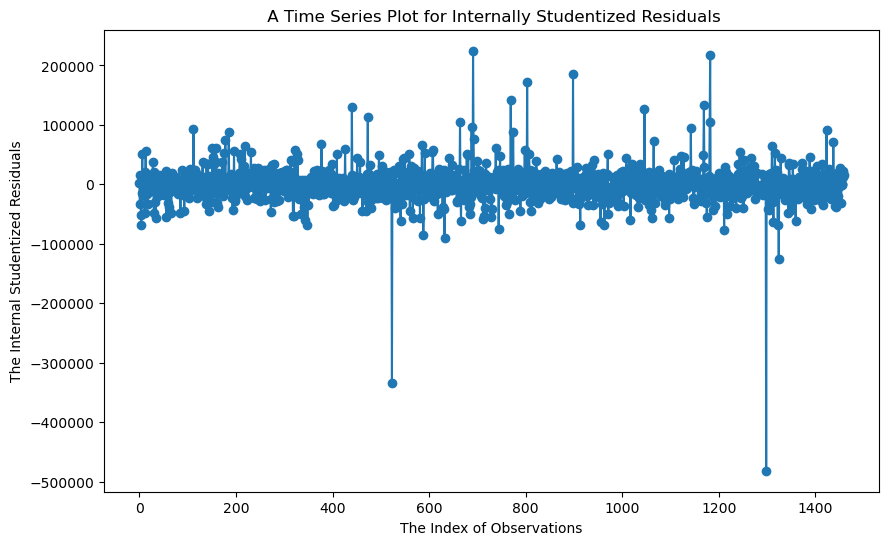

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
x = len(model.resid)
ax.plot(range(x), model.resid, marker= 'o', linestyle='-')
ax.set_xlabel('The Index of Observations')
ax.set_ylabel('The Internal Studentized Residuals')
ax.set_title(' A Time Series Plot for Internally Studentized Residuals')

plt.show() # No exact pattern in plot

# Influential Points

In [20]:
infl = model.get_influence()
#members
print(dir(infl))
print(infl.resid_studentized_external[1:5])


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_drop_vari', '_ols_xnoti', '_plot_index', '_res_looo', 'aux_regression_endog', 'aux_regression_exog', 'cooks_distance', 'cov_ratio', 'det_cov_params_not_obsi', 'dfbeta', 'dfbetas', 'dffits', 'dffits_internal', 'endog', 'ess_press', 'exog', 'get_resid_studentized_external', 'hat_diag_factor', 'hat_matrix_diag', 'influence', 'k_vars', 'model_class', 'nobs', 'params_not_obsi', 'plot_index', 'plot_influence', 'resid', 'resid_press', 'resid_std', 'resid_studentized', 'resid_studentized_external', 'resid_studentized_internal', 'resid_var', 'results', 'scale', 'sigma2_not_obsi', 'summary_frame', 'summary_table']
[-1.11488562  0.49855

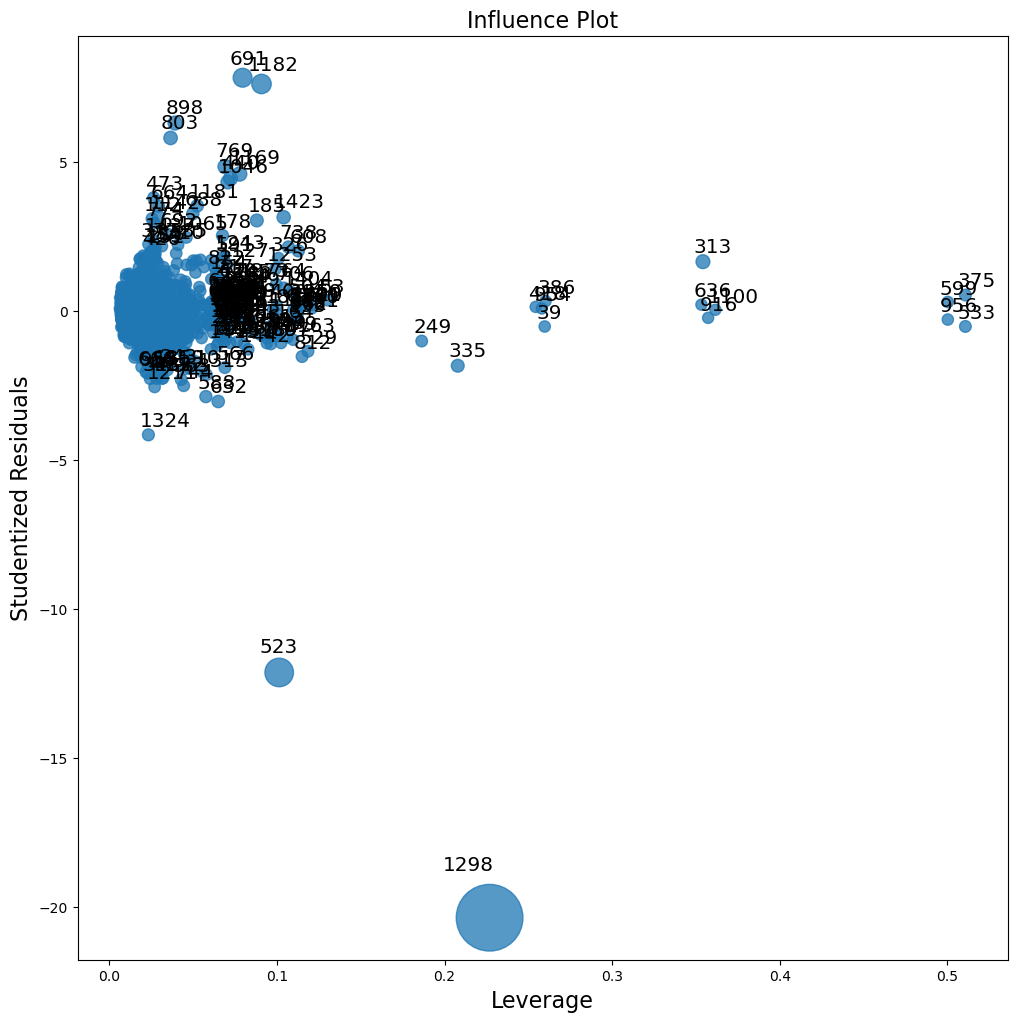

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks") 
 


In [23]:
import scipy
#df = pd.read_csv('train.csv')
n= 1460 #- 1432
p= 1460 - 1406
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
#print(atyp_stud)
#which ones?
#print(print(final_model.index()))
print(df.index[atyp_stud], reg_studs[atyp_stud]) #,

Int64Index([   4,  112,  151,  159,  178,  185,  218,  343,  348,  377,  426,
             440,  473,  523,  541,  585,  588,  608,  632,  664,  666,  688,
             691,  692,  738,  744,  769,  774,  803,  898,  913,  955,  963,
            1017, 1046, 1065, 1142, 1169, 1181, 1182, 1211, 1298, 1310, 1313,
            1322, 1324, 1359, 1423, 1437],
           dtype='int64') [ -2.27483454   3.09075266   2.01607012   2.04426791   2.52223464
   3.02778255   2.12439849  -1.98565345  -2.28035632   2.23140723
   1.9625279    4.43803154   3.79113529 -12.1298476   -2.06604017
   2.21053528  -2.87892805   2.0097357   -3.04319591   3.50441434
  -2.06215207   3.25785263   7.81559375   2.56740837   2.13645308
  -2.51178331   4.83545479   2.93958957   5.79662417   6.29619615
  -2.27892531  -2.10536977  -2.31036178  -2.04787709   4.31575399
   2.4623667    3.17027873   4.58767983   3.52122609   7.60619118
  -2.55403891 -20.3554321    2.16795622  -2.13892974  -2.25610419
  -4.16079861  -2.0378820

In [24]:
#Cook's distance
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(df.index[atyp_cook], reg_cook[atyp_cook])
list1=df.index[atyp_stud]

list2=df.index[atyp_cook]

Int64Index([   1,    3,    4,  112,  178,  185,  218,  249,  313,  326,  335,
             343,  348,  375,  440,  451,  473,  496,  523,  529,  533,  541,
             559,  566,  585,  588,  591,  608,  632,  664,  678,  681,  685,
             688,  691,  692,  712,  738,  744,  765,  769,  774,  798,  803,
             812,  897,  898,  913,  963, 1017, 1046, 1065, 1097, 1127, 1142,
            1169, 1181, 1182, 1211, 1243, 1253, 1267, 1298, 1310, 1313, 1322,
            1324, 1359, 1423, 1437, 1442],
           dtype='int64') 1       0.002880
3       0.003118
4       0.003244
112     0.005384
178     0.009972
          ...   
1324    0.008873
1359    0.002918
1423    0.024679
1437    0.003298
1442    0.003278
Name: cooks_d, Length: 71, dtype: float64


In [25]:
x = list(set(list1).intersection(list2))
print(list(x))


[769, 898, 4, 774, 523, 1423, 913, 1169, 1298, 1046, 664, 541, 1181, 1182, 1310, 1313, 1437, 803, 1065, 1322, 1324, 688, 178, 691, 692, 440, 185, 1211, 963, 585, 588, 1359, 343, 473, 218, 348, 608, 738, 744, 112, 1142, 632, 1017]


In [26]:
df.drop(df.index[[769, 898, 4, 774, 523, 1423, 913, 1169, 1298, 1046, 664, 541, 1181, 1182, 1310, 1313, 1437, 803, 1065, 1322, 1324, 688, 178, 691, 692, 440, 185, 1211, 963, 585, 588, 1359, 343, 473, 218, 348, 608, 738, 744, 112, 1142, 632, 1017]], inplace=True)

# New Model after Removing Outliers

In [82]:
model =smf.ols('SalePrice ~ LotArea + BsmtFinSF1 + TotalBsmtSF + GrLivArea + GarageCars + Neighborhood + C(OverallQual) + OverallCond + YearBuilt + SaleCondition',data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     400.2
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:12:10   Log-Likelihood:                -15921.
No. Observations:                1417   AIC:                         3.193e+04
Df Residuals:                    1371   BIC:                         3.218e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -8.764e+05   7.98e+04    -10.975      0.000   -1.03e+06    -7.2e+05
Neighborhood[T.Blueste]  -1.032e+04   1.41e+04     -0.733      0.464   -3.79e+04    1.73e+04
Neighborhood[T.BrDale]   -1.179e+04   6845.623     -1.722      0.085   -2.52e+04    1641.839
Neighborhood[T.BrkSide]   9563.2683   5883.157      1.626      0.104   -1977.695    2.11e+04
Neighborhood[T.ClearCr]   1.691e+04   6280.718      2.693      0.007    4592.448    2.92e+04
Neighborhood[T.CollgCr]   6794.3546   4865.265      1.397      0.163   -2749.815    1.63e+04
Neighborhood[T.Crawfor]   2.739e+04   5909.548      4.634      0.000    1.58e+04     3.9e+04
Neighborhood[T.Edwards]  -2372.9115   5417.517     -0.438      0.661    -1.3e+04    8254.609
Neighborhood[T.Gilbert]   8793.5877   5151.314      1.707      0.088   -1311.723    1.89e+04
Neighborhood[T.IDOTRR]    -163.8084   6246.392     -0.026      0.979   -1.24e+04    1.21e+04
Neighborhood[T.MeadowV]   -1.56e+04   6809.452     -2.290      0.022    -2.9e+04   -2237.334
Neighborhood[T.Mitchel]  -3003.7523   5510.866     -0.545      0.586   -1.38e+04    7806.891
Neighborhood[T.NAmes]     1039.7920   5132.183      0.203      0.839   -9027.990    1.11e+04
Neighborhood[T.NPkVill]  -3420.4377   7921.426     -0.432      0.666    -1.9e+04    1.21e+04
Neighborhood[T.NWAmes]     575.3448   5296.788      0.109      0.914   -9815.343     1.1e+04
Neighborhood[T.NoRidge]   3.881e+04   5858.494      6.624      0.000    2.73e+04    5.03e+04
Neighborhood[T.NridgHt]   2.281e+04   5316.322      4.290      0.000    1.24e+04    3.32e+04
Neighborhood[T.OldTown]  -5916.4976   5738.693     -1.031      0.303   -1.72e+04    5341.073
Neighborhood[T.SWISU]      984.4784   6669.395      0.148      0.883   -1.21e+04    1.41e+04
Neighborhood[T.Sawyer]   -1582.9088   5442.608     -0.291      0.771   -1.23e+04    9093.832
Neighborhood[T.SawyerW]   7529.4353   5332.698      1.412      0.158   -2931.696     1.8e+04
Neighborhood[T.Somerst]   1.311e+04   5031.463      2.605      0.009    3237.748     2.3e+04
Neighborhood[T.StoneBr]   2.615e+04   6419.810      4.073      0.000    1.36e+04    3.87e+04
Neighborhood[T.Timber]    3947.9308   5731.488      0.689      0.491   -7295.505    1.52e+04
Neighborhood[T.Veenker]   2.452e+04   7424.033      3.303      0.001    9956.148    3.91e+04
C(OverallQual)[T.2]      -1.184e+04   1.72e+04     -0.689      0.491   -4.56e+04    2.19e+04
C(OverallQual)[T.3]      -1.532e+04    1.4e+04     -1.093      0.275   -4.28e+04    1.22e+04
C(OverallQual)[T.4]        -1.5e+04   1.36e+04     -1.106      0.269   -4.16e+04    1.16e+04
C(OverallQual)[T.5]      -1.437e+04   1.36e+04     -1.058      0.290    -4.1e+04    1.23e+04
C(OverallQual)[T.6]      -9662.2092   1.37e+04     -0.708      0.479   -3.64e+04    1.71e+04
C(OverallQual)

# Breuschpagan test 

In [28]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 270.39197961019516, 'LM-Test p-value': 6.284535762435818e-34}


H0:presence of Homoscedasticity 
H1: presence of heteroscedasticity 

The results show that p_value of 6.2845357631217026e-34 < .05, so we reject the null hypothesis idicates the presence of heteroscedasticity.To solve for this, we make use of Robust Covariance transformation.


# Robust Cov Results

In [30]:
model=model.get_robustcov_results(cov_type = "HC0")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     357.2
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:51:04   Log-Likelihood:                -15921.
No. Observations:                1417   AIC:                         3.193e+04
Df Residuals:                    1371   BIC:                         3.218e+04
Df Model:                          45                                         
Covariance Type:                  HC0                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -8.764e+05   8.43e+04    -10.392      0.000   -1.04e+06   -7.11e+05
Neighborhood[T.Blueste]  -1.032e+04   6658.720     -1.549      0.122   -2.34e+04    2746.778
Neighborhood[T.BrDale]   -1.179e+04   5771.466     -2.042      0.041   -2.31e+04    -465.330
Neighborhood[T.BrkSide]   9563.2683   6117.639      1.563      0.118   -2437.678    2.16e+04
Neighborhood[T.ClearCr]   1.691e+04   7369.754      2.295      0.022    2456.091    3.14e+04
Neighborhood[T.CollgCr]   6794.3546   5183.810      1.311      0.190   -3374.703     1.7e+04
Neighborhood[T.Crawfor]   2.739e+04   6433.160      4.257      0.000    1.48e+04       4e+04
Neighborhood[T.Edwards]  -2372.9115   6006.416     -0.395      0.693   -1.42e+04    9409.849
Neighborhood[T.Gilbert]   8793.5877   5460.541      1.610      0.108   -1918.333    1.95e+04
Neighborhood[T.IDOTRR]    -163.8084   6349.175     -0.026      0.979   -1.26e+04    1.23e+04
Neighborhood[T.MeadowV]   -1.56e+04   6374.914     -2.446      0.015   -2.81e+04   -3089.764
Neighborhood[T.Mitchel]  -3003.7523   5825.549     -0.516      0.606   -1.44e+04    8424.203
Neighborhood[T.NAmes]     1039.7920   5539.444      0.188      0.851   -9826.911    1.19e+04
Neighborhood[T.NPkVill]  -3420.4377   5663.122     -0.604      0.546   -1.45e+04    7688.886
Neighborhood[T.NWAmes]     575.3448   5553.630      0.104      0.918   -1.03e+04    1.15e+04
Neighborhood[T.NoRidge]   3.881e+04   6942.900      5.589      0.000    2.52e+04    5.24e+04
Neighborhood[T.NridgHt]   2.281e+04   5936.696      3.842      0.000    1.12e+04    3.45e+04
Neighborhood[T.OldTown]  -5916.4976   5854.073     -1.011      0.312   -1.74e+04    5567.413
Neighborhood[T.SWISU]      984.4784   6749.154      0.146      0.884   -1.23e+04    1.42e+04
Neighborhood[T.Sawyer]   -1582.9088   5816.713     -0.272      0.786    -1.3e+04    9827.712
Neighborhood[T.SawyerW]   7529.4353   5628.786      1.338      0.181   -3512.531    1.86e+04
Neighborhood[T.Somerst]   1.311e+04   5421.251      2.418      0.016    2473.103    2.37e+04
Neighborhood[T.StoneBr]   2.615e+04   8479.447      3.084      0.002    9514.936    4.28e+04
Neighborhood[T.Timber]    3947.9308   6104.080      0.647      0.518   -8026.418    1.59e+04
Neighborhood[T.Veenker]   2.452e+04   9489.161      2.584      0.010    5904.995    4.31e+04
C(OverallQual)[T.2]      -1.184e+04   5183.178     -2.285      0.022    -2.2e+04   -1673.254
C(OverallQual)[T.3]      -1.532e+04   5201.780     -2.945      0.003   -2.55e+04   -5116.179
C(OverallQual)[T.4]        -1.5e+04   4828.036     -3.108      0.002   -2.45e+04   -5533.294
C(OverallQual)[T.5]      -1.437e+04   4815.827     -2.984      0.003   -2.38e+04   -4924.784
C(OverallQual)[T.6]      -9662.2092   5026.304     -1.922      0.055   -1.95e+04     197.870
C(OverallQual)

# K-test

In [31]:
from scipy.stats import kstest
kstest(model.resid,'norm')

KstestResult(statistic=0.5067043048694425, pvalue=0.0, statistic_location=-25.96668339325697, statistic_sign=1)

We  reject null hypothesis, so not normal

# Jarque-Bera test

In [33]:
from statsmodels.stats.stattools import jarque_bera
# Perform the Jarque-Bera test
jb_test_statistic, jb_p_value, skewness, kurtosis = jarque_bera(model.resid)
# Print the results
print(f'Jarque-Bera Test Statistic: {jb_test_statistic}')
print(f'p-value: {jb_p_value}')
print(f'Skewness of Residuals: {skewness}')
print(f'Kurtosis of Residuals: {kurtosis}')

Jarque-Bera Test Statistic: 74.02936780331142
p-value: 8.40866464224825e-17
Skewness of Residuals: 0.0660162872246273
Kurtosis of Residuals: 4.111942876149794


We  reject null hypothesis, so not normal

# Residual Plots

(array([ 10.,  26.,  76., 214., 486., 376., 159.,  41.,  23.,   6.]),
 array([-65330.36704101, -51783.56049663, -38236.75395225, -24689.94740787,
        -11143.14086349,   2403.66568089,  15950.47222527,  29497.27876965,
         43044.08531403,  56590.89185841,  70137.69840279]),
 <BarContainer object of 10 artists>)

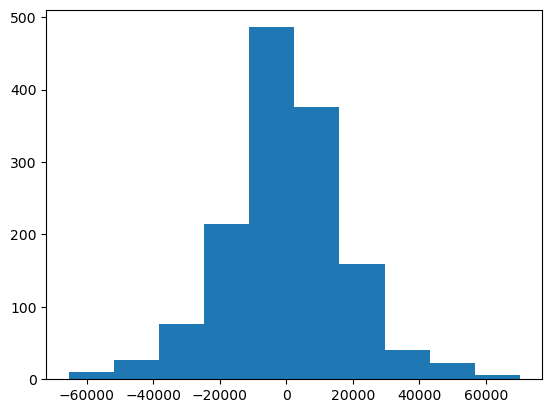

In [34]:
plt.hist(model.resid)

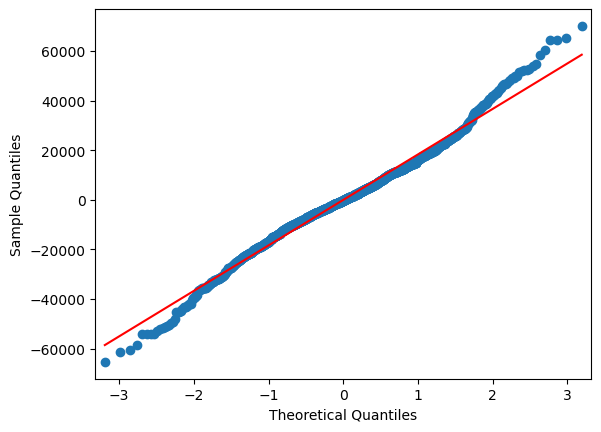

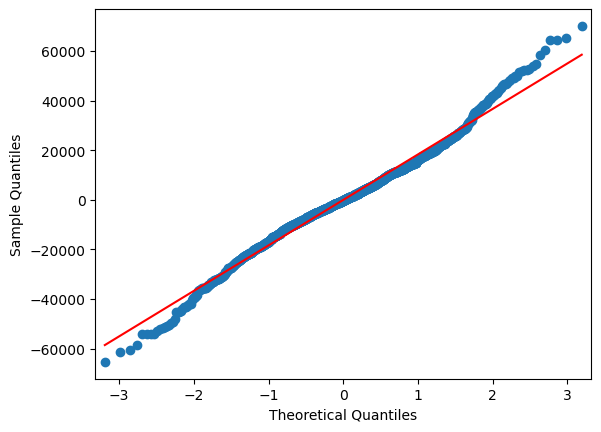

In [35]:
#QQ plot
sm.qqplot(model.resid, line ="s")

# Checking the Nonlinearity beween y and x

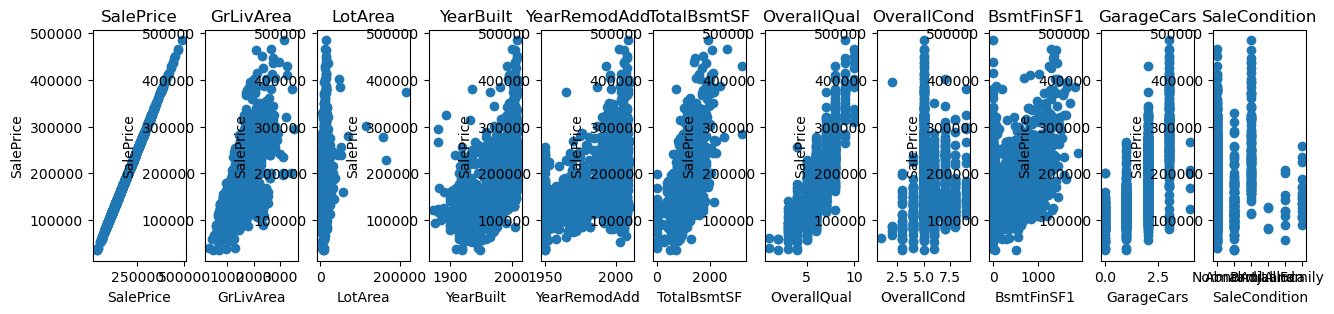

In [36]:
plt.figure(figsize=(20, 3))
#LotArea + GrLivArea + YearBuilt + YearRemodAdd + TotalBsmtSF + OverallQual + OverallCond + BsmtFinSF1 + GarageCars + Fence + Neighborhood
x = ['SalePrice', 'GrLivArea', "LotArea",'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'OverallQual', 'OverallCond', 'BsmtFinSF1', 'GarageCars', "SaleCondition"]
#LotArea + Condition1 + MSZoning + GrLivArea +  YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond  + SaleCondition + GarageCars + Neighborhood + C(OverallQual)
# i: index
for i, col in enumerate(x):
    plt.subplot(1, 14, i+1)
    x = df[col]
    y = df["SalePrice"]
    #print(col)
    #y = model.resid
    if (isinstance(x, float)):
        break
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('SalePrice')

# Checking Residual Plot

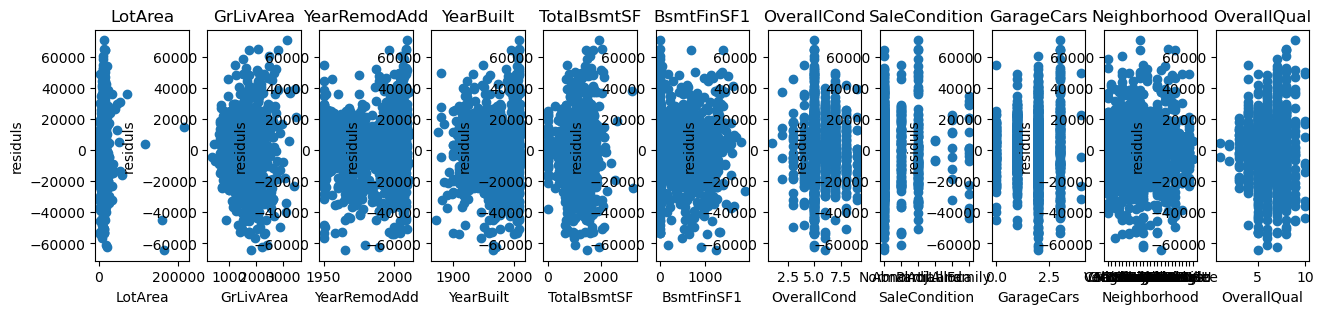

In [37]:
plt.figure(figsize=(20, 3))
model =smf.ols('SalePrice ~ LotArea + GrLivArea +  YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond  + SaleCondition + GarageCars + Neighborhood + C(OverallQual)',data=df).fit()
#p_values
x = ['SalePrice', "LotArea", 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'OverallQual', 'OverallCond', 'BsmtFinSF1', 'GarageCars', ]
#SaleCondition
x = ['LotArea', 'GrLivArea', 'YearRemodAdd', 'YearBuilt',
           'TotalBsmtSF', 'BsmtFinSF1', 'OverallCond', 'SaleCondition', 'GarageCars', 
           'Neighborhood', 'OverallQual']
# i: index
for i, col in enumerate(x):
    plt.subplot(1, 14, i+1)
    x = df[col]
    #print(col)
    y = model.resid
    if (isinstance(x, float)):
        break
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('residuls')

# Log transformation

In [38]:
df['log_price']=np.log(df['SalePrice']+1)
model_log =smf.ols('log_price ~ LotArea + GrLivArea +  YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond  + SaleCondition + GarageCars + Neighborhood + C(OverallQual)',data=df).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     325.6
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:52:36   Log-Likelihood:                 1117.7
No. Observations:                1417   AIC:                            -2141.
Df Residuals:                    1370   BIC:                            -1894.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.7875      0.554      6.841      0.000       2.701       4.873
SaleCondition[T.AdjLand]     0.1011      0.058      1.729      0.084      -0.014       0.216
SaleCondition[T.Alloca]     -0.1151      0.040     -2.874      0.004      -0.194      -0.037
SaleCondition[T.Family]      0.0473      0.028      1.669      0.095      -0.008       0.103
SaleCondition[T.Normal]      0.0829      0.012      6.939      0.000       0.059       0.106
SaleCondition[T.Partial]     0.1295      0.017      7.471      0.000       0.096       0.164
Neighborhood[T.Blueste]     -0.0890      0.085     -1.053      0.292      -0.255       0.077
Neighborhood[T.BrDale]      -0.1603      0.041     -3.891      0.000      -0.241      -0.079
Neighborhood[T.BrkSide]      0.0237      0.035      0.669      0.504      -0.046       0.093
Neighborhood[T.ClearCr]      0.1142      0.038      3.028      0.003       0.040       0.188
Neighborhood[T.CollgCr]      0.0330      0.029      1.131      0.258      -0.024       0.090
Neighborhood[T.Crawfor]      0.1528      0.036      4.299      0.000       0.083       0.223
Neighborhood[T.Edwards]     -0.0338      0.033     -1.039      0.299      -0.098       0.030
Neighborhood[T.Gilbert]      0.0522      0.031      1.688      0.092      -0.008       0.113
Neighborhood[T.IDOTRR]      -0.1009      0.038     -2.690      0.007      -0.175      -0.027
Neighborhood[T.MeadowV]     -0.1821      0.041     -4.449      0.000      -0.262      -0.102
Neighborhood[T.Mitchel]     -0.0183      0.033     -0.553      0.580      -0.083       0.047
Neighborhood[T.NAmes]        0.0150      0.031      0.484      0.629      -0.046       0.076
Neighborhood[T.NPkVill]     -0.0308      0.048     -0.647      0.518      -0.124       0.063
Neighborhood[T.NWAmes]       0.0099      0.032      0.309      0.757      -0.053       0.073
Neighborhood[T.NoRidge]      0.0805      0.035      2.287      0.022       0.011       0.150
Neighborhood[T.NridgHt]      0.0749      0.032      2.347      0.019       0.012       0.137
Neighborhood[T.OldTown]     -0.0664      0.034     -1.929      0.054      -0.134       0.001
Neighborhood[T.SWISU]        0.0295      0.040      0.736      0.462      -0.049       0.108
Neighborhood[T.Sawyer]      -0.0082      0.033     -0.250      0.803      -0.072       0.056
Neighborhood[T.SawyerW]      0.0241      0.032      0.754      0.451      -0.039       0.087
Neighborhood[T.Somerst]      0.0727      0.030      2.410      0.016       0.014       0.132
Neighborhood[T.StoneBr]      0.1058      0.039      2.744      0.006       0.030       0.181
Neighborhood[T.Timber]       0.0307      0.034      0.892      0.373      -0.037       0.098
Neighborhood[T.Veenker]      0.1106      0.045      2.479      0.013       0.023       0.198
C(OverallQual)

In [39]:
model=model_log.get_robustcov_results(cov_type = "HC0")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     417.9
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:52:51   Log-Likelihood:                 1117.7
No. Observations:                1417   AIC:                            -2141.
Df Residuals:                    1370   BIC:                            -1894.
Df Model:                          46                                         
Covariance Type:                  HC0                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.7875      0.638      5.939      0.000       2.536       5.038
SaleCondition[T.AdjLand]     0.1011      0.044      2.293      0.022       0.015       0.188
SaleCondition[T.Alloca]     -0.1151      0.058     -1.979      0.048      -0.229      -0.001
SaleCondition[T.Family]      0.0473      0.038      1.252      0.211      -0.027       0.121
SaleCondition[T.Normal]      0.0829      0.019      4.471      0.000       0.047       0.119
SaleCondition[T.Partial]     0.1295      0.021      6.218      0.000       0.089       0.170
Neighborhood[T.Blueste]     -0.0890      0.048     -1.859      0.063      -0.183       0.005
Neighborhood[T.BrDale]      -0.1603      0.034     -4.708      0.000      -0.227      -0.094
Neighborhood[T.BrkSide]      0.0237      0.037      0.642      0.521      -0.049       0.096
Neighborhood[T.ClearCr]      0.1142      0.038      3.037      0.002       0.040       0.188
Neighborhood[T.CollgCr]      0.0330      0.027      1.228      0.220      -0.020       0.086
Neighborhood[T.Crawfor]      0.1528      0.035      4.380      0.000       0.084       0.221
Neighborhood[T.Edwards]     -0.0338      0.034     -0.982      0.326      -0.101       0.034
Neighborhood[T.Gilbert]      0.0522      0.028      1.870      0.062      -0.003       0.107
Neighborhood[T.IDOTRR]      -0.1009      0.050     -2.033      0.042      -0.198      -0.004
Neighborhood[T.MeadowV]     -0.1821      0.036     -4.999      0.000      -0.254      -0.111
Neighborhood[T.Mitchel]     -0.0183      0.032     -0.576      0.565      -0.081       0.044
Neighborhood[T.NAmes]        0.0150      0.030      0.499      0.618      -0.044       0.074
Neighborhood[T.NPkVill]     -0.0308      0.031     -0.989      0.323      -0.092       0.030
Neighborhood[T.NWAmes]       0.0099      0.030      0.333      0.739      -0.048       0.068
Neighborhood[T.NoRidge]      0.0805      0.032      2.553      0.011       0.019       0.142
Neighborhood[T.NridgHt]      0.0749      0.028      2.645      0.008       0.019       0.130
Neighborhood[T.OldTown]     -0.0664      0.034     -1.948      0.052      -0.133       0.000
Neighborhood[T.SWISU]        0.0295      0.039      0.749      0.454      -0.048       0.107
Neighborhood[T.Sawyer]      -0.0082      0.033     -0.249      0.804      -0.073       0.056
Neighborhood[T.SawyerW]      0.0241      0.030      0.816      0.415      -0.034       0.082
Neighborhood[T.Somerst]      0.0727      0.027      2.666      0.008       0.019       0.126
Neighborhood[T.StoneBr]      0.1058      0.032      3.263      0.001       0.042       0.169
Neighborhood[T.Timber]       0.0307      0.030      1.015      0.310      -0.029       0.090
Neighborhood[T.Veenker]      0.1106      0.042      2.615      0.009       0.028       0.194
C(OverallQual)

In [40]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model_log.resid, model_log.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 220.08423196589527, 'LM-Test p-value': 1.4740665708511495e-24}


In [36]:
#df['log_Condition_1']=np.log(df['Condition1']+1)

In [83]:
model =smf.ols('SalePrice ~ LotArea + BsmtFinSF1 + TotalBsmtSF + GrLivArea + GarageCars + Neighborhood + C(OverallQual) + OverallCond + YearBuilt + SaleCondition',data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     400.2
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:12:54   Log-Likelihood:                -15921.
No. Observations:                1417   AIC:                         3.193e+04
Df Residuals:                    1371   BIC:                         3.218e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -8.764e+05   7.98e+04    -10.975      0.000   -1.03e+06    -7.2e+05
Neighborhood[T.Blueste]  -1.032e+04   1.41e+04     -0.733      0.464   -3.79e+04    1.73e+04
Neighborhood[T.BrDale]   -1.179e+04   6845.623     -1.722      0.085   -2.52e+04    1641.839
Neighborhood[T.BrkSide]   9563.2683   5883.157      1.626      0.104   -1977.695    2.11e+04
Neighborhood[T.ClearCr]   1.691e+04   6280.718      2.693      0.007    4592.448    2.92e+04
Neighborhood[T.CollgCr]   6794.3546   4865.265      1.397      0.163   -2749.815    1.63e+04
Neighborhood[T.Crawfor]   2.739e+04   5909.548      4.634      0.000    1.58e+04     3.9e+04
Neighborhood[T.Edwards]  -2372.9115   5417.517     -0.438      0.661    -1.3e+04    8254.609
Neighborhood[T.Gilbert]   8793.5877   5151.314      1.707      0.088   -1311.723    1.89e+04
Neighborhood[T.IDOTRR]    -163.8084   6246.392     -0.026      0.979   -1.24e+04    1.21e+04
Neighborhood[T.MeadowV]   -1.56e+04   6809.452     -2.290      0.022    -2.9e+04   -2237.334
Neighborhood[T.Mitchel]  -3003.7523   5510.866     -0.545      0.586   -1.38e+04    7806.891
Neighborhood[T.NAmes]     1039.7920   5132.183      0.203      0.839   -9027.990    1.11e+04
Neighborhood[T.NPkVill]  -3420.4377   7921.426     -0.432      0.666    -1.9e+04    1.21e+04
Neighborhood[T.NWAmes]     575.3448   5296.788      0.109      0.914   -9815.343     1.1e+04
Neighborhood[T.NoRidge]   3.881e+04   5858.494      6.624      0.000    2.73e+04    5.03e+04
Neighborhood[T.NridgHt]   2.281e+04   5316.322      4.290      0.000    1.24e+04    3.32e+04
Neighborhood[T.OldTown]  -5916.4976   5738.693     -1.031      0.303   -1.72e+04    5341.073
Neighborhood[T.SWISU]      984.4784   6669.395      0.148      0.883   -1.21e+04    1.41e+04
Neighborhood[T.Sawyer]   -1582.9088   5442.608     -0.291      0.771   -1.23e+04    9093.832
Neighborhood[T.SawyerW]   7529.4353   5332.698      1.412      0.158   -2931.696     1.8e+04
Neighborhood[T.Somerst]   1.311e+04   5031.463      2.605      0.009    3237.748     2.3e+04
Neighborhood[T.StoneBr]   2.615e+04   6419.810      4.073      0.000    1.36e+04    3.87e+04
Neighborhood[T.Timber]    3947.9308   5731.488      0.689      0.491   -7295.505    1.52e+04
Neighborhood[T.Veenker]   2.452e+04   7424.033      3.303      0.001    9956.148    3.91e+04
C(OverallQual)[T.2]      -1.184e+04   1.72e+04     -0.689      0.491   -4.56e+04    2.19e+04
C(OverallQual)[T.3]      -1.532e+04    1.4e+04     -1.093      0.275   -4.28e+04    1.22e+04
C(OverallQual)[T.4]        -1.5e+04   1.36e+04     -1.106      0.269   -4.16e+04    1.16e+04
C(OverallQual)[T.5]      -1.437e+04   1.36e+04     -1.058      0.290    -4.1e+04    1.23e+04
C(OverallQual)[T.6]      -9662.2092   1.37e+04     -0.708      0.479   -3.64e+04    1.71e+04
C(OverallQual)

In [84]:
model=model.get_robustcov_results(cov_type = "HC0")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     357.2
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:13:00   Log-Likelihood:                -15921.
No. Observations:                1417   AIC:                         3.193e+04
Df Residuals:                    1371   BIC:                         3.218e+04
Df Model:                          45                                         
Covariance Type:                  HC0                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -8.764e+05   8.43e+04    -10.392      0.000   -1.04e+06   -7.11e+05
Neighborhood[T.Blueste]  -1.032e+04   6658.720     -1.549      0.122   -2.34e+04    2746.778
Neighborhood[T.BrDale]   -1.179e+04   5771.466     -2.042      0.041   -2.31e+04    -465.330
Neighborhood[T.BrkSide]   9563.2683   6117.639      1.563      0.118   -2437.678    2.16e+04
Neighborhood[T.ClearCr]   1.691e+04   7369.754      2.295      0.022    2456.091    3.14e+04
Neighborhood[T.CollgCr]   6794.3546   5183.810      1.311      0.190   -3374.703     1.7e+04
Neighborhood[T.Crawfor]   2.739e+04   6433.160      4.257      0.000    1.48e+04       4e+04
Neighborhood[T.Edwards]  -2372.9115   6006.416     -0.395      0.693   -1.42e+04    9409.849
Neighborhood[T.Gilbert]   8793.5877   5460.541      1.610      0.108   -1918.333    1.95e+04
Neighborhood[T.IDOTRR]    -163.8084   6349.175     -0.026      0.979   -1.26e+04    1.23e+04
Neighborhood[T.MeadowV]   -1.56e+04   6374.914     -2.446      0.015   -2.81e+04   -3089.764
Neighborhood[T.Mitchel]  -3003.7523   5825.549     -0.516      0.606   -1.44e+04    8424.203
Neighborhood[T.NAmes]     1039.7920   5539.444      0.188      0.851   -9826.911    1.19e+04
Neighborhood[T.NPkVill]  -3420.4377   5663.122     -0.604      0.546   -1.45e+04    7688.886
Neighborhood[T.NWAmes]     575.3448   5553.630      0.104      0.918   -1.03e+04    1.15e+04
Neighborhood[T.NoRidge]   3.881e+04   6942.900      5.589      0.000    2.52e+04    5.24e+04
Neighborhood[T.NridgHt]   2.281e+04   5936.696      3.842      0.000    1.12e+04    3.45e+04
Neighborhood[T.OldTown]  -5916.4976   5854.073     -1.011      0.312   -1.74e+04    5567.413
Neighborhood[T.SWISU]      984.4784   6749.154      0.146      0.884   -1.23e+04    1.42e+04
Neighborhood[T.Sawyer]   -1582.9088   5816.713     -0.272      0.786    -1.3e+04    9827.712
Neighborhood[T.SawyerW]   7529.4353   5628.786      1.338      0.181   -3512.531    1.86e+04
Neighborhood[T.Somerst]   1.311e+04   5421.251      2.418      0.016    2473.103    2.37e+04
Neighborhood[T.StoneBr]   2.615e+04   8479.447      3.084      0.002    9514.936    4.28e+04
Neighborhood[T.Timber]    3947.9308   6104.080      0.647      0.518   -8026.418    1.59e+04
Neighborhood[T.Veenker]   2.452e+04   9489.161      2.584      0.010    5904.995    4.31e+04
C(OverallQual)[T.2]      -1.184e+04   5183.178     -2.285      0.022    -2.2e+04   -1673.254
C(OverallQual)[T.3]      -1.532e+04   5201.780     -2.945      0.003   -2.55e+04   -5116.179
C(OverallQual)[T.4]        -1.5e+04   4828.036     -3.108      0.002   -2.45e+04   -5533.294
C(OverallQual)[T.5]      -1.437e+04   4815.827     -2.984      0.003   -2.38e+04   -4924.784
C(OverallQual)[T.6]      -9662.2092   5026.304     -1.922      0.055   -1.95e+04     197.870
C(OverallQual)

# ANOVA Test

In [87]:
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
Neighborhood,24.0,3.948332e+12,1.645138e+11,473.426979,0.000000e+00
C(OverallQual),9.0,1.401620e+12,1.557356e+11,448.165508,0.000000e+00
SaleCondition,5.0,4.847727e+10,9.695454e+09,27.900930,5.496072e-27
LotArea,1.0,1.237309e+11,1.237309e+11,356.064643,8.692749e-71
BsmtFinSF1,1.0,1.164268e+11,1.164268e+11,335.045321,3.936810e-67
TotalBsmtSF,1.0,8.467559e+10,8.467559e+10,243.673777,1.094633e-50
GrLivArea,1.0,3.854240e+11,3.854240e+11,1109.147404,1.077829e-178
GarageCars,1.0,3.493778e+10,3.493778e+10,100.541626,6.965227e-23
OverallCond,1.0,7.126671e+10,7.126671e+10,205.086574,1.871164e-43
YearBuilt,1.0,4.297845e+10,4.297845e+10,123.680503,1.436466e-27


In [88]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
Neighborhood,1.049221e+11,24.0,12.580740,1.712654e-44
C(OverallQual),2.095507e+11,9.0,67.003459,3.482308e-102
SaleCondition,2.914382e+10,5.0,16.773628,4.089912e-16
LotArea,1.053809e+10,1.0,30.325815,4.355434e-08
BsmtFinSF1,4.006696e+10,1.0,115.302039,6.991501e-26
TotalBsmtSF,3.479395e+10,1.0,100.127702,8.462647e-23
GrLivArea,2.698389e+11,1.0,776.524366,8.897841e-136
GarageCars,2.352380e+10,1.0,67.695225,4.389580e-16
OverallCond,1.053049e+11,1.0,303.039551,1.781697e-61
YearBuilt,3.741619e+10,1.0,107.673815,2.454383e-24


In [89]:
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,3.752927e+10,1.0,107.999241,2.107822e-24
Neighborhood,1.049221e+11,24.0,12.580740,1.712654e-44
C(OverallQual),2.095507e+11,9.0,67.003459,3.482308e-102
SaleCondition,2.914382e+10,5.0,16.773628,4.089912e-16
LotArea,1.053809e+10,1.0,30.325815,4.355434e-08
BsmtFinSF1,4.006696e+10,1.0,115.302039,6.991501e-26
TotalBsmtSF,3.479395e+10,1.0,100.127702,8.462647e-23
GrLivArea,2.698389e+11,1.0,776.524366,8.897841e-136
GarageCars,2.352380e+10,1.0,67.695225,4.389580e-16
OverallCond,1.053049e+11,1.0,303.039551,1.781697e-61


In [46]:
model.pvalues

array([8.33279174e-017, 3.14089397e-002, 4.44633864e-007, 6.84969171e-001,
       4.04135325e-003, 2.48908802e-001, 3.76976984e-005, 2.35335680e-001,
       7.06692212e-002, 2.96603088e-002, 1.47184258e-007, 4.48605820e-001,
       9.26339637e-001, 1.67673927e-001, 9.30248849e-001, 2.06862039e-002,
       1.00170011e-002, 3.87388572e-002, 5.75141120e-001, 6.33702542e-001,
       5.21486604e-001, 8.08564555e-003, 2.03639801e-003, 4.06666089e-001,
       1.93955702e-002, 7.47169705e-001, 1.49720599e-001, 3.47445146e-002,
       1.16741597e-002, 4.73794772e-003, 7.60875450e-004, 8.13018574e-005,
       1.10733030e-006, 7.04375569e-007, 1.08876232e-002, 5.33553145e-002,
       2.05149180e-001, 7.91508043e-006, 2.31433324e-010, 1.46740187e-007,
       8.33894197e-031, 8.05990693e-028, 1.47771776e-154, 1.34458620e-018,
       1.38672361e-054, 1.50160486e-025])

Year sold needs to be removed, since the F-test is close to 0 in all types of tests for ANOVA

# Order of the Model

In [90]:
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
Neighborhood,24.0,3.948332e+12,1.645138e+11,473.426979,0.000000e+00
C(OverallQual),9.0,1.401620e+12,1.557356e+11,448.165508,0.000000e+00
SaleCondition,5.0,4.847727e+10,9.695454e+09,27.900930,5.496072e-27
LotArea,1.0,1.237309e+11,1.237309e+11,356.064643,8.692749e-71
BsmtFinSF1,1.0,1.164268e+11,1.164268e+11,335.045321,3.936810e-67
TotalBsmtSF,1.0,8.467559e+10,8.467559e+10,243.673777,1.094633e-50
GrLivArea,1.0,3.854240e+11,3.854240e+11,1109.147404,1.077829e-178
GarageCars,1.0,3.493778e+10,3.493778e+10,100.541626,6.965227e-23
OverallCond,1.0,7.126671e+10,7.126671e+10,205.086574,1.871164e-43
YearBuilt,1.0,4.297845e+10,4.297845e+10,123.680503,1.436466e-27


In [91]:
sm.stats.anova_lm(model.get_robustcov_results(cov_type = "HC0"), typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
Neighborhood,24.0,3.948332e+12,1.645138e+11,473.426979,0.000000e+00
C(OverallQual),9.0,1.401620e+12,1.557356e+11,448.165508,0.000000e+00
SaleCondition,5.0,4.847727e+10,9.695454e+09,27.900930,5.496072e-27
LotArea,1.0,1.237309e+11,1.237309e+11,356.064643,8.692749e-71
BsmtFinSF1,1.0,1.164268e+11,1.164268e+11,335.045321,3.936810e-67
TotalBsmtSF,1.0,8.467559e+10,8.467559e+10,243.673777,1.094633e-50
GrLivArea,1.0,3.854240e+11,3.854240e+11,1109.147404,1.077829e-178
GarageCars,1.0,3.493778e+10,3.493778e+10,100.541626,6.965227e-23
OverallCond,1.0,7.126671e+10,7.126671e+10,205.086574,1.871164e-43
YearBuilt,1.0,4.297845e+10,4.297845e+10,123.680503,1.436466e-27


In [92]:
model =smf.ols('SalePrice ~ LotArea + BsmtFinSF1 + SaleCondition + TotalBsmtSF + GarageCars + GrLivArea + Neighborhood + C(OverallQual) + OverallCond + YearBuilt',data=df).fit()
sm.stats.anova_lm(model, typ=1) # shows order of model
#LotArea + GrLivArea + YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond + GarageCars + Neighborhood + C(OverallQual)

,df,sum_sq,mean_sq,F,PR(>F)
SaleCondition,5.0,8.628379e+11,1.725676e+11,496.603447,1.383730e-304
Neighborhood,24.0,3.191238e+12,1.329683e+11,382.647191,0.000000e+00
C(OverallQual),9.0,1.344354e+12,1.493727e+11,429.854654,0.000000e+00
LotArea,1.0,1.237309e+11,1.237309e+11,356.064643,8.692749e-71
BsmtFinSF1,1.0,1.164268e+11,1.164268e+11,335.045321,3.936810e-67
TotalBsmtSF,1.0,8.467559e+10,8.467559e+10,243.673777,1.094633e-50
GarageCars,1.0,9.011864e+10,9.011864e+10,259.337405,1.425102e-53
GrLivArea,1.0,3.302431e+11,3.302431e+11,950.351625,5.630969e-159
OverallCond,1.0,7.126671e+10,7.126671e+10,205.086574,1.871164e-43
YearBuilt,1.0,4.297845e+10,4.297845e+10,123.680503,1.436466e-27


In [93]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     400.2
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:13:37   Log-Likelihood:                -15921.
No. Observations:                1417   AIC:                         3.193e+04
Df Residuals:                    1371   BIC:                         3.218e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -8.764e+05   7.98e+04    -10.975      0.000   -1.03e+06    -7.2e+05
SaleCondition[T.AdjLand]  2.131e+04   9746.181      2.186      0.029    2187.000    4.04e+04
SaleCondition[T.Alloca]  -1.821e+04   6674.683     -2.728      0.006   -3.13e+04   -5111.898
SaleCondition[T.Family]   2139.7636   4720.171      0.453      0.650   -7119.777    1.14e+04
SaleCondition[T.Normal]   1.006e+04   1991.866      5.052      0.000    6154.944     1.4e+04
SaleCondition[T.Partial]  2.601e+04   2882.933      9.020      0.000    2.03e+04    3.17e+04
Neighborhood[T.Blueste]  -1.032e+04   1.41e+04     -0.733      0.464   -3.79e+04    1.73e+04
Neighborhood[T.BrDale]   -1.179e+04   6845.623     -1.722      0.085   -2.52e+04    1641.839
Neighborhood[T.BrkSide]   9563.2683   5883.157      1.626      0.104   -1977.695    2.11e+04
Neighborhood[T.ClearCr]   1.691e+04   6280.718      2.693      0.007    4592.448    2.92e+04
Neighborhood[T.CollgCr]   6794.3546   4865.265      1.397      0.163   -2749.815    1.63e+04
Neighborhood[T.Crawfor]   2.739e+04   5909.548      4.634      0.000    1.58e+04     3.9e+04
Neighborhood[T.Edwards]  -2372.9115   5417.517     -0.438      0.661    -1.3e+04    8254.609
Neighborhood[T.Gilbert]   8793.5877   5151.314      1.707      0.088   -1311.723    1.89e+04
Neighborhood[T.IDOTRR]    -163.8084   6246.392     -0.026      0.979   -1.24e+04    1.21e+04
Neighborhood[T.MeadowV]   -1.56e+04   6809.452     -2.290      0.022    -2.9e+04   -2237.334
Neighborhood[T.Mitchel]  -3003.7523   5510.866     -0.545      0.586   -1.38e+04    7806.891
Neighborhood[T.NAmes]     1039.7920   5132.183      0.203      0.839   -9027.990    1.11e+04
Neighborhood[T.NPkVill]  -3420.4377   7921.426     -0.432      0.666    -1.9e+04    1.21e+04
Neighborhood[T.NWAmes]     575.3448   5296.788      0.109      0.914   -9815.343     1.1e+04
Neighborhood[T.NoRidge]   3.881e+04   5858.494      6.624      0.000    2.73e+04    5.03e+04
Neighborhood[T.NridgHt]   2.281e+04   5316.322      4.290      0.000    1.24e+04    3.32e+04
Neighborhood[T.OldTown]  -5916.4976   5738.693     -1.031      0.303   -1.72e+04    5341.073
Neighborhood[T.SWISU]      984.4784   6669.395      0.148      0.883   -1.21e+04    1.41e+04
Neighborhood[T.Sawyer]   -1582.9088   5442.608     -0.291      0.771   -1.23e+04    9093.832
Neighborhood[T.SawyerW]   7529.4353   5332.698      1.412      0.158   -2931.696     1.8e+04
Neighborhood[T.Somerst]   1.311e+04   5031.463      2.605      0.009    3237.748     2.3e+04
Neighborhood[T.StoneBr]   2.615e+04   6419.810      4.073      0.000    1.36e+04    3.87e+04
Neighborhood[T.Timber]    3947.9308   5731.488      0.689      0.491   -7295.505    1.52e+04
Neighborhood[T.Veenker]   2.452e+04   7424.033      3.303      0.001    9956.148    3.91e+04
C(OverallQual)

# Model Selection

In [99]:
res_mse_final = model.mse_resid
import itertools
predict = []
# List of predictor variables
predictors =  ['LotArea', 'BsmtFinSF1', 'SaleCondition', 'TotalBsmtSF',  
            'GarageCars', 'GrLivArea',  
           'Neighborhood', 'C(OverallQual)', 'OverallCond','YearBuilt']

#SalePrice ~ LotArea + BsmtFinSF1 + SaleCondition + TotalBsmtSF + GarageCars + GrLivArea + Neighborhood + C(OverallQual) + OverallCond + YearBuilt

# Get all possible combinations of predictors
all_combinations = []
for r in range(1, len(predictors) + 1):
    #print(r)
    combinations_r = list(itertools.combinations(predictors, r))
    all_combinations.extend(combinations_r)

# Print all possible combinations
Cp_values = []
for combination in all_combinations:
    predict.append(" + ".join(combination))
def cpval(res_mse_final, pred):
    model =smf.ols(f'SalePrice ~{pred}',data=df).fit()
    model.summary()

    ns = len(model.params)  
    p = 11 #model.

    SSE = model.ssr

    n = model.nobs
#print(ns)


    Cp = (SSE / res_mse_final) - (n - 2*ns)
    # Print all possible combinations
    aic = model.aic
    bic = model.bic
    r2 = model.rsquared
    r2a = model.rsquared_adj
    #jb_stat, jb_p_value = jarque_bera(model.resid)
    #jb = 
    Cp_values.append([model,pred,Cp, bic, aic, r2a, r2])
    #print(pred,':' ,Cp)
for i in predict:
    cpval(res_mse_final, i)

In [100]:
dfs = pd.DataFrame(Cp_values, columns=["model", "Predictors",'Cp', 'BIC', 'AIC', "adj_R^2", 'R^2'])
df_sort = dfs.sort_values(by='adj_R^2', ascending = False).sort_values(by=['BIC','AIC','Cp'], ascending = True)
df_sort

,model,Predictors,Cp,BIC,AIC,adj_R^2,R^2
1022,<statsmodels.regression.linear_model.Regressio...,LotArea + BsmtFinSF1 + SaleCondition + TotalBs...,3.781042e+13,32175.392796,31933.603123,0.926933,0.929255
1017,<statsmodels.regression.linear_model.Regressio...,LotArea + BsmtFinSF1 + SaleCondition + TotalBs...,3.990384e+13,32244.495712,32007.962336,0.922944,0.925338
1019,<statsmodels.regression.linear_model.Regressio...,LotArea + BsmtFinSF1 + TotalBsmtSF + GarageCar...,4.073562e+13,32244.703599,32029.195412,0.921566,0.923782
1015,<statsmodels.regression.linear_model.Regressio...,LotArea + BsmtFinSF1 + SaleCondition + TotalBs...,4.577421e+13,32272.081539,32156.443000,0.913065,0.914354
1021,<statsmodels.regression.linear_model.Regressio...,BsmtFinSF1 + SaleCondition + TotalBsmtSF + Gar...,4.078466e+13,32275.433599,32038.900223,0.921243,0.923690
...,...,...,...,...,...,...,...
2,<statsmodels.regression.linear_model.Regressio...,SaleCondition,4.659828e+14,35444.027077,35412.489294,0.125037,0.128126
32,<statsmodels.regression.linear_model.Regressio...,SaleCondition + OverallCond,4.648748e+14,35447.909969,35411.115889,0.126498,0.130199
17,<statsmodels.regression.linear_model.Regressio...,LotArea + OverallCond,4.959460e+14,35510.563200,35494.794308,0.070751,0.072064
0,<statsmodels.regression.linear_model.Regressio...,LotArea,4.994320e+14,35513.232258,35502.719663,0.064881,0.065541


In [101]:
x = list(df_sort["Predictors"])[0]
x


'LotArea + BsmtFinSF1 + SaleCondition + TotalBsmtSF + GarageCars + GrLivArea + Neighborhood + C(OverallQual) + OverallCond + YearBuilt'

In [102]:
final_model = list(df_sort["model"])[0]
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     400.2
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:15:08   Log-Likelihood:                -15921.
No. Observations:                1417   AIC:                         3.193e+04
Df Residuals:                    1371   BIC:                         3.218e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -8.764e+05   7.98e+04    -10.975      0.000   -1.03e+06    -7.2e+05
SaleCondition[T.AdjLand]  2.131e+04   9746.181      2.186      0.029    2187.000    4.04e+04
SaleCondition[T.Alloca]  -1.821e+04   6674.683     -2.728      0.006   -3.13e+04   -5111.898
SaleCondition[T.Family]   2139.7636   4720.171      0.453      0.650   -7119.777    1.14e+04
SaleCondition[T.Normal]   1.006e+04   1991.866      5.052      0.000    6154.944     1.4e+04
SaleCondition[T.Partial]  2.601e+04   2882.933      9.020      0.000    2.03e+04    3.17e+04
Neighborhood[T.Blueste]  -1.032e+04   1.41e+04     -0.733      0.464   -3.79e+04    1.73e+04
Neighborhood[T.BrDale]   -1.179e+04   6845.623     -1.722      0.085   -2.52e+04    1641.839
Neighborhood[T.BrkSide]   9563.2683   5883.157      1.626      0.104   -1977.695    2.11e+04
Neighborhood[T.ClearCr]   1.691e+04   6280.718      2.693      0.007    4592.448    2.92e+04
Neighborhood[T.CollgCr]   6794.3546   4865.265      1.397      0.163   -2749.815    1.63e+04
Neighborhood[T.Crawfor]   2.739e+04   5909.548      4.634      0.000    1.58e+04     3.9e+04
Neighborhood[T.Edwards]  -2372.9115   5417.517     -0.438      0.661    -1.3e+04    8254.609
Neighborhood[T.Gilbert]   8793.5877   5151.314      1.707      0.088   -1311.723    1.89e+04
Neighborhood[T.IDOTRR]    -163.8084   6246.392     -0.026      0.979   -1.24e+04    1.21e+04
Neighborhood[T.MeadowV]   -1.56e+04   6809.452     -2.290      0.022    -2.9e+04   -2237.334
Neighborhood[T.Mitchel]  -3003.7523   5510.866     -0.545      0.586   -1.38e+04    7806.891
Neighborhood[T.NAmes]     1039.7920   5132.183      0.203      0.839   -9027.990    1.11e+04
Neighborhood[T.NPkVill]  -3420.4377   7921.426     -0.432      0.666    -1.9e+04    1.21e+04
Neighborhood[T.NWAmes]     575.3448   5296.788      0.109      0.914   -9815.343     1.1e+04
Neighborhood[T.NoRidge]   3.881e+04   5858.494      6.624      0.000    2.73e+04    5.03e+04
Neighborhood[T.NridgHt]   2.281e+04   5316.322      4.290      0.000    1.24e+04    3.32e+04
Neighborhood[T.OldTown]  -5916.4976   5738.693     -1.031      0.303   -1.72e+04    5341.073
Neighborhood[T.SWISU]      984.4784   6669.395      0.148      0.883   -1.21e+04    1.41e+04
Neighborhood[T.Sawyer]   -1582.9088   5442.608     -0.291      0.771   -1.23e+04    9093.832
Neighborhood[T.SawyerW]   7529.4353   5332.698      1.412      0.158   -2931.696     1.8e+04
Neighborhood[T.Somerst]   1.311e+04   5031.463      2.605      0.009    3237.748     2.3e+04
Neighborhood[T.StoneBr]   2.615e+04   6419.810      4.073      0.000    1.36e+04    3.87e+04
Neighborhood[T.Timber]    3947.9308   5731.488      0.689      0.491   -7295.505    1.52e+04
Neighborhood[T.Veenker]   2.452e+04   7424.033      3.303      0.001    9956.148    3.91e+04
C(OverallQual)

In [103]:
model=final_model.get_robustcov_results(cov_type = "HC0")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     357.2
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:15:08   Log-Likelihood:                -15921.
No. Observations:                1417   AIC:                         3.193e+04
Df Residuals:                    1371   BIC:                         3.218e+04
Df Model:                          45                                         
Covariance Type:                  HC0                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -8.764e+05   8.43e+04    -10.392      0.000   -1.04e+06   -7.11e+05
SaleCondition[T.AdjLand]  2.131e+04   5010.136      4.253      0.000    1.15e+04    3.11e+04
SaleCondition[T.Alloca]  -1.821e+04   6370.812     -2.858      0.004   -3.07e+04   -5708.000
SaleCondition[T.Family]   2139.7636   5952.500      0.359      0.719   -9537.231    1.38e+04
SaleCondition[T.Normal]   1.006e+04   2312.373      4.352      0.000    5526.206    1.46e+04
SaleCondition[T.Partial]  2.601e+04   3511.930      7.405      0.000    1.91e+04    3.29e+04
Neighborhood[T.Blueste]  -1.032e+04   6658.720     -1.549      0.122   -2.34e+04    2746.778
Neighborhood[T.BrDale]   -1.179e+04   5771.466     -2.042      0.041   -2.31e+04    -465.330
Neighborhood[T.BrkSide]   9563.2683   6117.639      1.563      0.118   -2437.678    2.16e+04
Neighborhood[T.ClearCr]   1.691e+04   7369.754      2.295      0.022    2456.091    3.14e+04
Neighborhood[T.CollgCr]   6794.3546   5183.810      1.311      0.190   -3374.703     1.7e+04
Neighborhood[T.Crawfor]   2.739e+04   6433.160      4.257      0.000    1.48e+04       4e+04
Neighborhood[T.Edwards]  -2372.9115   6006.416     -0.395      0.693   -1.42e+04    9409.849
Neighborhood[T.Gilbert]   8793.5877   5460.541      1.610      0.108   -1918.333    1.95e+04
Neighborhood[T.IDOTRR]    -163.8084   6349.175     -0.026      0.979   -1.26e+04    1.23e+04
Neighborhood[T.MeadowV]   -1.56e+04   6374.914     -2.446      0.015   -2.81e+04   -3089.764
Neighborhood[T.Mitchel]  -3003.7523   5825.549     -0.516      0.606   -1.44e+04    8424.203
Neighborhood[T.NAmes]     1039.7920   5539.444      0.188      0.851   -9826.911    1.19e+04
Neighborhood[T.NPkVill]  -3420.4377   5663.122     -0.604      0.546   -1.45e+04    7688.886
Neighborhood[T.NWAmes]     575.3448   5553.630      0.104      0.918   -1.03e+04    1.15e+04
Neighborhood[T.NoRidge]   3.881e+04   6942.900      5.589      0.000    2.52e+04    5.24e+04
Neighborhood[T.NridgHt]   2.281e+04   5936.696      3.842      0.000    1.12e+04    3.45e+04
Neighborhood[T.OldTown]  -5916.4976   5854.073     -1.011      0.312   -1.74e+04    5567.413
Neighborhood[T.SWISU]      984.4784   6749.154      0.146      0.884   -1.23e+04    1.42e+04
Neighborhood[T.Sawyer]   -1582.9088   5816.713     -0.272      0.786    -1.3e+04    9827.712
Neighborhood[T.SawyerW]   7529.4353   5628.786      1.338      0.181   -3512.531    1.86e+04
Neighborhood[T.Somerst]   1.311e+04   5421.251      2.418      0.016    2473.103    2.37e+04
Neighborhood[T.StoneBr]   2.615e+04   8479.447      3.084      0.002    9514.936    4.28e+04
Neighborhood[T.Timber]    3947.9308   6104.080      0.647      0.518   -8026.418    1.59e+04
Neighborhood[T.Veenker]   2.452e+04   9489.161      2.584      0.010    5904.995    4.31e+04
C(OverallQual)

# MSE

In [104]:
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

y_pred1 = df["SalePrice"]
preds = model.predict()
mse = mean_squared_error(y_pred1, preds)
print(np.sqrt(mse))

18336.165957942787


In [105]:
preds

array([205321.50594051, 212828.39741616, 207006.49604853, ...,
       253154.62608691, 118223.2721811 , 148187.45384786])

In [106]:
y_pred1

0       208500
1       181500
2       223500
3       140000
5       143000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1417, dtype: int64

In [ ]:
#accuracy = accuracy_score(y_pred1, preds)
#print("Give the accuracy", accuracy)

#  Logistic Regression

In [107]:
df["Sale_Price_binary_mean"] = (df["SalePrice"] > df["SalePrice"].mean()).astype(int) #df_3["Sale_Price_binary"].mean()
df["Sale_Price_binary_mean"]


0       1
1       1
2       1
3       0
5       0
       ..
1455    0
1456    1
1457    1
1458    0
1459    0
Name: Sale_Price_binary_mean, Length: 1417, dtype: int64

In [108]:
formula = 'Sale_Price_binary_mean~LotArea + MSZoning + GrLivArea + YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond + SaleCondition + GarageCars + Neighborhood + C(OverallQual)'
model2 = smf.glm(formula = formula, data=df, family=sm.families.Binomial()).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     Sale_Price_binary_mean   No. Observations:                 1417
Model:                                GLM   Df Residuals:                     1366
Model Family:                    Binomial   Df Model:                           50
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -191.26
Date:                    Thu, 12 Oct 2023   Deviance:                       382.52
Time:                            20:20:34   Pearson chi2:                     610.
No. Iterations:                        24   Pseudo R-squ. (CS):             0.6624
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 -281.4654   1.59e+05     -0.002      0.999   -3.12e+05    3.12e+05
MSZoning[T.FV]               5.6340   6.29e+04   8.95e-05      1.000   -1.23e+05    1.23e+05
MSZoning[T.RH]              24.7926   4.83e+04      0.001      1.000   -9.45e+04    9.46e+04
MSZoning[T.RL]              24.9513   4.83e+04      0.001      1.000   -9.45e+04    9.46e+04
MSZoning[T.RM]              22.4574   4.83e+04      0.000      1.000   -9.46e+04    9.46e+04
SaleCondition[T.AdjLand]   -15.7969    8.4e+04     -0.000      1.000   -1.65e+05    1.65e+05
SaleCondition[T.Alloca]      3.8852      1.916      2.028      0.043       0.131       7.640
SaleCondition[T.Family]     -0.3272      1.346     -0.243      0.808      -2.966       2.311
SaleCondition[T.Normal]      2.2762      0.689      3.305      0.001       0.926       3.626
SaleCondition[T.Partial]     1.5371      0.819      1.878      0.060      -0.067       3.141
Neighborhood[T.Blueste]    -19.2510   1.46e+05     -0.000      1.000   -2.87e+05    2.87e+05
Neighborhood[T.BrDale]     -15.7103   4.61e+04     -0.000      1.000   -9.04e+04    9.03e+04
Neighborhood[T.BrkSide]      4.4929      1.440      3.121      0.002       1.671       7.315
Neighborhood[T.ClearCr]      2.2694      1.282      1.770      0.077      -0.243       4.782
Neighborhood[T.CollgCr]      0.9817      0.859      1.143      0.253      -0.702       2.665
Neighborhood[T.Crawfor]      4.5907      1.317      3.487      0.000       2.010       7.171
Neighborhood[T.Edwards]      0.3986      0.997      0.400      0.689      -1.556       2.353
Neighborhood[T.Gilbert]      0.7759      0.839      0.925      0.355      -0.868       2.419
Neighborhood[T.IDOTRR]     -14.1343   2.83e+04     -0.000      1.000   -5.55e+04    5.55e+04
Neighborhood[T.MeadowV]    -22.0481   3.71e+04     -0.001      1.000   -7.28e+04    7.28e+04
Neighborhood[T.Mitchel]     -2.6431      1.187     -2.227      0.026      -4.969      -0.317
Neighborhood[T.NAmes]       -0.5339      0.988     -0.540      0.589      -2.470       1.403
Neighborhood[T.NPkVill]    -21.9283    6.7e+04     -0.000      1.000   -1.31e+05    1.31e+05
Neighborhood[T.NWAmes]       0.2749      0.931      0.295      0.768      -1.551       2.101
Neighborhood[T.NoRidge]     17.8789   2.85e+04      0.001      0.999   -5.58e+04    5.58e+04
Neighborhood[T.NridgHt]      0.0941      0.983      0.096      0.924      -1.832       2.021
Neighborhood[T.OldTown]      1.1723      1.825      0.642      0.521      -2.405       4.750
Neighborhood[T.SWISU]        1.2599      1.584      0.795      0.426      -1.844       4.364
Neighborhood[T.Sawyer]      -2.5848      1.472     -1.756      0.079      -5.469       0.300
Neighborhood[T.SawyerW]      0.4062      0.941      0.432      

In [109]:
wald_test_results = model2.wald_test(np.eye(len(model2.params)))

# Display the results
print("Wald Test Results:")
print(wald_test_results)

Wald Test Results:
<Wald test (chi2): statistic=[[152.83662095]], p-value=1.1591642618233834e-13, df_denom=45>


/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 45
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [110]:
df["Sale_Price_binary_median"] = (df["SalePrice"] > df["SalePrice"].median()).astype(int) #df_3["Sale_Price_binary"].mean()
df["Sale_Price_binary_median"]

0       1
1       1
2       1
3       0
5       0
       ..
1455    1
1456    1
1457    1
1458    0
1459    0
Name: Sale_Price_binary_median, Length: 1417, dtype: int64

In [111]:
formula = 'Sale_Price_binary_median~LotArea + MSZoning + GrLivArea + YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond + SaleCondition + GarageCars + Neighborhood + C(OverallQual)'
model2_1 = smf.glm(formula = formula, data=df, family=sm.families.Binomial()).fit()
model2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                     
====================================================================================
Dep. Variable:     Sale_Price_binary_median   No. Observations:                 1417
Model:                                  GLM   Df Residuals:                     1366
Model Family:                      Binomial   Df Model:                           50
Link Function:                        Logit   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -216.37
Date:                      Thu, 12 Oct 2023   Deviance:                       432.75
Time:                              20:20:42   Pearson chi2:                     690.
No. Iterations:                          25   Pseudo R-squ. (CS):             0.6607
Covariance Type:                  nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 -192.6868   2.63e+05     -0.001      0.999   -5.17e+05    5.16e+05
MSZoning[T.FV]               8.6823    9.8e+04   8.86e-05      1.000   -1.92e+05    1.92e+05
MSZoning[T.RH]              26.1759   8.04e+04      0.000      1.000   -1.58e+05    1.58e+05
MSZoning[T.RL]              28.0970   8.04e+04      0.000      1.000   -1.58e+05    1.58e+05
MSZoning[T.RM]              25.7544   8.04e+04      0.000      1.000   -1.58e+05    1.58e+05
SaleCondition[T.AdjLand]   -17.6599   1.51e+05     -0.000      1.000   -2.95e+05    2.95e+05
SaleCondition[T.Alloca]     -0.2066      2.499     -0.083      0.934      -5.104       4.691
SaleCondition[T.Family]     -0.3820      1.108     -0.345      0.730      -2.553       1.789
SaleCondition[T.Normal]      1.9753      0.616      3.209      0.001       0.769       3.182
SaleCondition[T.Partial]     2.2226      0.907      2.451      0.014       0.445       4.000
Neighborhood[T.Blueste]    -24.2762   2.44e+05  -9.95e-05      1.000   -4.78e+05    4.78e+05
Neighborhood[T.BrDale]     -20.8453   7.74e+04     -0.000      1.000   -1.52e+05    1.52e+05
Neighborhood[T.BrkSide]      1.7797      1.540      1.155      0.248      -1.239       4.799
Neighborhood[T.ClearCr]      2.2320      1.732      1.289      0.197      -1.162       5.626
Neighborhood[T.CollgCr]     -0.1360      1.265     -0.108      0.914      -2.615       2.343
Neighborhood[T.Crawfor]      2.5711      1.484      1.733      0.083      -0.337       5.480
Neighborhood[T.Edwards]     -1.3190      1.299     -1.016      0.310      -3.864       1.226
Neighborhood[T.Gilbert]      1.4415      1.394      1.034      0.301      -1.291       4.174
Neighborhood[T.IDOTRR]       3.5728      1.878      1.902      0.057      -0.108       7.254
Neighborhood[T.MeadowV]    -26.2770   6.34e+04     -0.000      1.000   -1.24e+05    1.24e+05
Neighborhood[T.Mitchel]     -0.2104      1.315     -0.160      0.873      -2.787       2.366
Neighborhood[T.NAmes]       -0.8671      1.290     -0.672      0.501      -3.395       1.660
Neighborhood[T.NPkVill]    -26.5572   1.11e+05     -0.000      1.000   -2.18e+05    2.18e+05
Neighborhood[T.NWAmes]       0.0842      1.301      0.065      0.948      -2.465       2.634
Neighborhood[T.NoRidge]     18.0948    4.3e+04      0.000      1.000   -8.42e+04    8.42e+04
Neighborhood[T.NridgHt]     21.4211   3.21e+04      0.001      0.999   -6.28e+04    6.29e+04
Neighborhood[T.OldTown]      0.3118      1.560      0.200      0.842      -2.746       3.370
Neighborhood[T.SWISU]       -0.1379      1.596     -0.086      0.931      -3.266       2.990
Neighborhood[T.Sawyer]      -0.6607      1.351     -0.489      0.625      -3.308       1.986
Neighborhood[T.SawyerW]     -0.9826      

In [2]:
# (2 *8) - (2*(-13548))

# Wald test

In [113]:
wald_test_results = model2_1.wald_test(np.eye(len(model2_1.params)))

# Display the results
print("Wald Test Results:")
print(wald_test_results)

Wald Test Results:
<Wald test (chi2): statistic=[[189.69228888]], p-value=1.1159527873544673e-19, df_denom=45>


/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 45
  warnings.warn('covariance of constraints does not have full '
/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [79]:
df_test = pd.read_csv("test.csv")
df_test


FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [59]:
pred = (model2_1.predict() > .5).astype(int) #median
pred2 = (model2.predict() > .5).astype(int) # mean
#log_predict
pred2

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
# pred

# Appendix

# Compared to the median

In [ ]:
 from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
y_pred = df["SalePrice"]
y_pred_2 = df["Sale_Price_binary_median"]
mse = mean_squared_error(y_pred_2, pred)
print(mse)
accuracy = accuracy_score(y_pred_2, pred)
print("Give the accuracy", accuracy)

# Compared to mean

In [ ]:
y_pred_2 = df["Sale_Price_binary_mean"]
mse = mean_squared_error(y_pred_2, pred2)
print(mse)
accuracy = accuracy_score(y_pred_2, pred2)
print("Give the accuracy", accuracy)

In [ ]:
sm.qqplot(model.resid, line ="s" )

# Dummy Variables

In [ ]:
train_dummies = pd.get_dummies(df).astype(float)
list(train_dummies.columns)

In [ ]:
merge = pd.merge(df, train_dummies[["Id", "Neighborhood_Blmngtn", "Neighborhood_BrDale", "Neighborhood_BrkSide" , "Neighborhood_CollgCr" , "Neighborhood_Edwards" , "Neighborhood_Gilbert" , "Neighborhood_IDOTRR" , "Neighborhood_MeadowV" , "Neighborhood_Mitchel" , "Neighborhood_NAmes" , "Neighborhood_NPkVill" , "Neighborhood_NWAmes" , "Neighborhood_NoRidge", "Neighborhood_NridgHt", "Neighborhood_OldTown", "Neighborhood_SWISU", "Neighborhood_Sawyer", "Neighborhood_SawyerW", "Neighborhood_StoneBr"]], how = "inner", on = "Id")
merge

In [ ]:
modeldum =smf.ols('SalePrice ~ + LotArea + GrLivArea + YearBuilt + YearRemodAdd + TotalBsmtSF + C(OverallQual) + OverallCond + BsmtFinSF1 + GarageCars + Neighborhood_Blmngtn + Neighborhood_BrDale + Neighborhood_BrkSide + Neighborhood_CollgCr + Neighborhood_Edwards + Neighborhood_Gilbert + Neighborhood_IDOTRR + Neighborhood_MeadowV + Neighborhood_Mitchel + Neighborhood_NAmes + Neighborhood_NPkVill + Neighborhood_NWAmes + Neighborhood_NoRidge + Neighborhood_NridgHt + Neighborhood_OldTown + Neighborhood_SWISU + Neighborhood_Sawyer + Neighborhood_SawyerW + Neighborhood_StoneBr',data=merge).fit()
modeldum.summary()

In [ ]:
y, X_new = dmatrices('SalePrice ~ GrLivArea + YearBuilt + YearRemodAdd + TotalBsmtSF + C(OverallQual) + OverallCond + BsmtFinSF1 + GarageCars + Neighborhood_Blmngtn + Neighborhood_BrDale + Neighborhood_BrkSide + Neighborhood_CollgCr + Neighborhood_Edwards + Neighborhood_Gilbert + Neighborhood_IDOTRR + Neighborhood_MeadowV + Neighborhood_Mitchel + Neighborhood_NAmes + Neighborhood_NPkVill + Neighborhood_NWAmes + Neighborhood_NoRidge + Neighborhood_NridgHt + Neighborhood_OldTown + Neighborhood_SWISU + Neighborhood_Sawyer + Neighborhood_SawyerW + Neighborhood_StoneBr + Fence + LotArea', data= merge, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns
print(vif)

# Model Selections

In [ ]:
model =smf.ols('SalePrice ~ LotArea + Condition1 + MSZoning + GrLivArea +  YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond  + SaleCondition + GarageCars + Neighborhood + C(OverallQual)',data=df).fit()

res_mse_final = model.mse_resid

In [ ]:
model.summary()

In [ ]:
res_mse_final = model.mse_resid
import itertools
predict = []
# List of predictor variables
predictors =  ['LotArea', 'Condition1', 'MSZoning', 'GrLivArea', 'YearRemodAdd', 'YearBuilt',
           'TotalBsmtSF', 'BsmtFinSF1', 'OverallCond', 'SaleCondition', 'GarageCars', 
           'Neighborhood', 'C(OverallQual)']

# Get all possible combinations of predictors
all_combinations = []
for r in range(1, len(predictors) + 1):
    #print(r)
    combinations_r = list(itertools.combinations(predictors, r))
    all_combinations.extend(combinations_r)

# Print all possible combinations
Cp_values = []
for combination in all_combinations:
    predict.append(" + ".join(combination))
def cpval(res_mse_final, pred):
    model =smf.ols(f'SalePrice ~{pred}',data=df).fit()
    model.summary()

    ns = len(model.params)  
    p = 11 #model.

    SSE = model.ssr

    n = model.nobs
#print(ns)


    Cp = (SSE / res_mse_final) - (n - 2*ns)
    # Print all possible combinations
    aic = model.aic
    bic = model.bic
    r2 = model.rsquared
    r2a = model.rsquared_adj
    jb_stat, jb_p_value = jarque_bera(model.resid)
    #jb = 
    Cp_values.append([model,pred,Cp, bic, aic, r2a, r2, jb_p_value, jb_stat])
    #print(pred,':' ,Cp)
for i in predict:
    cpval(res_mse_final, i)

In [ ]:
dfs = pd.DataFrame(Cp_values, columns=["model", "Predictors",'Cp', 'BIC', 'AIC', "adj_R^2", 'R^2', "jb_p_value", "jb_stat"])
df_sort = dfs.sort_values(by='Cp', ascending = True).sort_values(by=['BIC','AIC','Cp'], ascending = True)
df_sort

In [ ]:
x = list(df_sort["Predictors"])[0]
x

In [ ]:
x = list(df_sort["Predictors"])[0]
x
final_model = list(df_sort["model"])[0]
final_model.summary()

# Inflection Points

In [ ]:
infl = final_model.get_influence()
#members
print(dir(infl))


In [ ]:
infl = final_model.get_influence()
#members
print(dir(infl))
print(infl.resid_studentized_external[1:5])

In [ ]:
infl = final_model.get_influence()
#members
print(dir(infl))
print(infl.resid_studentized_external[1:5])
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(final_model,ax=ax, criterion="cooks") 

In [ ]:
infl = final_model.get_influence()
#members
print(dir(infl))
print(infl.resid_studentized_external[1:5])
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(final_model,ax=ax, criterion="cooks") 
import scipy
df = pd.read_csv('train.csv')
n= 1460 #- 1432
p= 1460 - 1419
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
#print(atyp_stud)
#which ones?
#print(print(final_model.index()))
print(df.index[atyp_stud], reg_studs[atyp_stud]) #, 

In [ ]:
list1

In [ ]:
list2

# Remove the outliers

In [ ]:
df

# Our New Model

In [ ]:
model =smf.ols('SalePrice ~ LotArea + GrLivArea + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond + SaleCondition + GarageCars + Neighborhood + C(OverallQual)',data=df).fit()
model.summary()#LotArea + OverallCond + GarageCars + TotalBsmtSF + BsmtFinSF1 + GrLivArea + C(OverallQual) + YearBuilt + C(Neighborhood)
res_mse_final = model.mse_resid
ns = len(model.params)  
p = 10 #model.

SSE = model.ssr

n = model.nobs
#print(ns)


Cp = (SSE / res_mse_final) - (n - 2*(ns))

print(Cp)
model.summary()

In [ ]:
y, X_new = dmatrices('SalePrice ~ LotArea + GrLivArea + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond + SaleCondition + GarageCars + Neighborhood + C(OverallQual)', data=df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns
print(vif)

In [ ]:
sm.stats.anova_lm(model, typ=1)

In [ ]:
sm.stats.anova_lm(model, typ=2)

In [ ]:
sm.stats.anova_lm(model, typ=3)

In [ ]:
p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

In [ ]:
plt.hist(model.resid)

In [ ]:
sm.qqplot(model.resid, line ="s" )

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
x = len(model.resid)
ax.plot(range(x), model.resid, marker= 'o', linestyle='-')
ax.set_xlabel('The Index of Observations')
ax.set_ylabel('The Internal Studentized Residuals')
ax.set_title(' A Time Series Plot for Internally Studentized Residuals')

plt.show()

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

In [ ]:
kstest(model.resid,'norm')

In [ ]:
for i in predict:
    cpval(res_mse_final, i)

In [ ]:
dfs = pd.DataFrame(Cp_values, columns=["model", "Predictors",'Cp', 'BIC', 'AIC', "adj_R^2", 'R^2', "jb_p_value", "jb_stat"])
df_sort = dfs.sort_values(by='Cp', ascending = True).sort_values(by=['BIC','AIC','Cp'], ascending = True)
df_sort

In [ ]:
Final_model = list(df_sort["model"])[0] #
Final_model.summary()

In [ ]:
Final_model.summary()

In [ ]:
list(df_sort["Predictors"])[0]

In [ ]:
y, X_new = dmatrices('SalePrice ~ LotArea + MSZoning + GrLivArea + YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond + SaleCondition + GarageCars + Neighborhood + C(OverallQual)', data=df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns
print(vif)

In [ ]:
sm.stats.anova_lm(Final_model, typ=1)

In [ ]:
sm.stats.anova_lm(Final_model, typ=2)

In [ ]:
sm.stats.anova_lm(Final_model, typ=3)

In [ ]:
p = Final_model.fittedvalues
res = Final_model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

In [ ]:
plt.hist(Final_model.resid)

In [ ]:
sm.qqplot(Final_model.resid, line ="s" )

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
x = len(Final_model.resid)
ax.plot(range(x), Final_model.resid, marker= 'o', linestyle='-')
ax.set_xlabel('The Index of Observations')
ax.set_ylabel('The Internal Studentized Residuals')
ax.set_title(' A Time Series Plot for Internally Studentized Residuals')

plt.show()

# Trying Log_Price Again

In [ ]:
model =smf.ols('log_price ~ LotArea + MSZoning + GrLivArea + YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond + SaleCondition + GarageCars + Neighborhood + C(OverallQual)',data=df).fit()
log_predict = model.predict()
model.summary()

Did not improve the model

# Logistic Regression

In [ ]:
df["Sale_Price_binary_mean"] = (df["SalePrice"] > df["SalePrice"].mean()).astype(int) #df_3["Sale_Price_binary"].mean()
df["Sale_Price_binary_mean"]

In [ ]:
df["Sale_Price_binary_mean"] = (df["SalePrice"] > df["SalePrice"].mean()).astype(int) #df_3["Sale_Price_binary"].mean()
df["Sale_Price_binary_mean"]
formula = 'Sale_Price_binary_mean~LotArea + MSZoning + GrLivArea + YearRemodAdd + YearBuilt + TotalBsmtSF + BsmtFinSF1 + OverallCond + SaleCondition + GarageCars + Neighborhood + C(OverallQual)'
model2 = smf.glm(formula = formula, data=df, family=sm.families.Binomial()).fit()
model2.summary()

# Logistic Regression with Median

# Using the the extra Point

In [ ]:
df_test = pd.read_csv("test.csv")
df_test

In [ ]:
model =smf.ols('SalePrice ~ LotArea + OverallCond + GarageCars + TotalBsmtSF + BsmtFinSF1 + GrLivArea + C(OverallQual) + YearBuilt + C(Neighborhood) + Sale_Price_binary_mean',data=df).fit()
model.summary()

In [ ]:
df_test = pd.read_csv("test.csv")
df_test
value = model.predict()
log_predict

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
y_pred = df["SalePrice"]
mse = mean_squared_error(y_pred, log_predict)
mse
#accuracy = accuracy_score(y_pred, log_predict)